<a href="https://colab.research.google.com/github/jaymekirchner/fakeJobPosts/blob/master/jaymekirchner_finalproject_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Real & Fake Job Postings
Dataset obtained from Kaggle: https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction

## Importing Dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.python.ops.math_ops import reduce_prod
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from keras.layers.embeddings import Embedding

In [ ]:
jobs_file = tf.keras.utils.get_file(
    fname="./fraudulent_jobs.csv", 
    origin="https://uofi.box.com/shared/static/sfw0eqvj7q49vmexpztqke7xzhspevnb.csv"
)

df=pd.read_csv(jobs_file)

df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
#drop jobs_id column and update 'work_remote' to 'work_remote's
df.drop(columns=['job_id'], inplace=True)
df.rename(columns={'telecommuting': 'work_remote'}, inplace=True)
df.columns

Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'work_remote',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')

## Exploring the Dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17534 non-null  object
 2   department           6333 non-null   object
 3   salary_range         2868 non-null   object
 4   company_profile      14572 non-null  object
 5   description          17879 non-null  object
 6   requirements         15185 non-null  object
 7   benefits             10670 non-null  object
 8   work_remote          17880 non-null  int64 
 9   has_company_logo     17880 non-null  int64 
 10  has_questions        17880 non-null  int64 
 11  employment_type      14409 non-null  object
 12  required_experience  10830 non-null  object
 13  required_education   9775 non-null   object
 14  industry             12977 non-null  object
 15  function             11425 non-null  object
 16  frau

In [ ]:
df.nunique() #get # of unique values in dataset

title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11968
benefits                6205
work_remote                2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64

In [ ]:
df.isna().sum()

title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
work_remote                0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [ ]:
df['fraudulent'].value_counts()
#data is very imbalanced

0    17014
1      866
Name: fraudulent, dtype: int64

* Text columns are title, location, department, company profile, description, requirements, and benefits, industry, function. 
* Categorical columns are employment type, required experience, and required education
* Numeric variables are salary (low/high), work_remote, has company logo, and has questions
* Column to Predict is fraudulent

In [ ]:
#separate columns based on their type
text_cols = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits']
categorical_cols = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
numeric_cols = ['work_remote', 'has_company_logo', 'has_questions', 'salary_low', 'salary_high']
col_to_predict = ['fraudulent']

## Cleaning Dataset


### Text Data

In [ ]:
def move_column(df, col):
  df['Temp_Col'] = df[col]
  df.drop(columns=[col], inplace=True)
  df.rename(columns={'Temp_Col': col}, inplace=True)
  return df

In [ ]:
df['employment_type'].fillna('No Data', inplace=True)
df['required_experience'].fillna('No Data', inplace=True)
df['required_education'].fillna('No Data', inplace=True)
df['industry'].fillna('No Data', inplace=True)
df['function'].fillna('No Data', inplace=True)

In [ ]:
df.isna().sum()

title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
work_remote                0
has_company_logo           0
has_questions              0
employment_type            0
required_experience        0
required_education         0
industry                   0
function                   0
fraudulent                 0
dtype: int64

In [ ]:
df.notna().sum()

title                  17880
location               17534
department              6333
salary_range            2868
company_profile        14572
description            17879
requirements           15185
benefits               10670
work_remote            17880
has_company_logo       17880
has_questions          17880
employment_type        17880
required_experience    17880
required_education     17880
industry               17880
function               17880
fraudulent             17880
dtype: int64

In [ ]:
df[df['description'].isna()] #only 1 row with an empty description -- the post only has title and location and it is a fraud post --> keeping it

,title,location,department,salary_range,company_profile,description,requirements,benefits,work_remote,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
17513,Office Manager,"PL, MZ, Warsaw",NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,No Data,No Data,No Data,No Data,No Data,1


In [ ]:
#rows that are entirely null in the text columns
null_text = df[(df['location'].isna()) & (df['department'].isna()) & (df['company_profile'].isna()) & (df['requirements'].isna()) & (df['benefits'].isna())]
# 'title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits'
print(f"There are {null_text.shape[0]} rows where all text columns aside from 'title' and 'description' are empty. Of these rows, {null_text['fraudulent'].sum()} are fraudulent posts.")

There are 19 rows where all text columns aside from 'title' and 'description' are empty. Of these rows, 12 are fraudulent posts.


In [ ]:
for col in text_cols:
  df[col].fillna(value=" ", inplace=True)
  print(f"Max length of '{col}': {df[col].map(len).max()}") #get maximum number of characters in each column

Max length of 'title': 142
Max length of 'location': 161
Max length of 'department': 255
Max length of 'company_profile': 6178
Max length of 'description': 14907
Max length of 'requirements': 10864
Max length of 'benefits': 4429


In [ ]:
#combine all text into 1 column - full_text
df['full_text'] = df['title'] + " " + df['location'] + " " + df['department']  + " " + df['company_profile']  + " " + df['description']  + " " + df['requirements']  + " "  + df['benefits'] 
df['full_text'][0]

"Marketing Intern US, NY, New York Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food communi

In [ ]:
print(f"Min length of 'full text': {df['full_text'].map(len).min()}")
print(f"Max length of 'full text': {df['full_text'].map(len).max()}")

Min length of 'full text': 33
Max length of 'full text': 14964


In [ ]:
def update_text(new_df): 
  new_df['full_text'] = new_df['full_text'].str.replace(pat='US', repl='USA', case=True)
  new_df['location'] = new_df['location'].str.replace(pat='US', repl='USA', case=True)
  return new_df

In [ ]:
# update US with USA so it does not get mixed up with the word 'us'
df = update_text(df)

#replace urls, email, phone numbers (contact details) ?? maybe presence/absence could indicate a fake post?
# df['full_text'] = df['full_text'].replace(r'http\S+', '', regex=True).replace(r'www\S+', ' ', regex=True).replace(r'#PHONE\S+', '', regex=True).replace(r'#EMAIL\S+', '', regex=True)

In [ ]:
#separate 2 separate words that have been put together (i.e. PinterestLoves -> Pinterest Loves)
def space_words(all_text):
  import re
  # print('start', all_text)
  result = re.sub('(?<=[A-Za-z])(?=[A-Z][a-z])', '~', all_text)
  result = re.split('~', result)
  result = ' '.join(result)
  all_text = result
  # print('end',all_text)
  return all_text

In [ ]:
texts = ['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'full_text']

for col in texts:
  df[col] = df[col].apply(space_words)

In [ ]:
df.head(1)

,title,location,department,salary_range,company_profile,description,requirements,benefits,work_remote,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,full_text
0,Marketing Intern,"USA, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,No Data,No Data,Marketing,0,"Marketing Intern USA, NY, New York Marketing W..."


In [ ]:
def get_unique_words(new_df, col):
  unique_words = []
  idx = list(new_df.index.values)
  for i in idx:
    x = list(new_df[col][i].split())
    unique_words += x 
  return unique_words

In [ ]:
for col in texts: 
  print(f'Number of total words in {col}: {len(get_unique_words(df, col))}')
  print(f'Number of unique words in {col}: {len(set(get_unique_words(df, col)))}\n')

Number of total words in title: 67673
Number of unique words in title: 7819

Number of total words in location: 55748
Number of unique words in location: 2713

Number of total words in department: 8883
Number of unique words in department: 1218

Number of total words in company_profile: 1668791
Number of unique words in company_profile: 28263

Number of total words in description: 3110058
Number of unique words in description: 127256

Number of total words in requirements: 1457316
Number of unique words in requirements: 85515

Number of total words in benefits: 553944
Number of unique words in benefits: 27944

Number of total words in employment_type: 21351
Number of unique words in employment_type: 7

Number of total words in required_experience: 32552
Number of unique words in required_experience: 11

Number of total words in required_education: 38486
Number of unique words in required_education: 22

Number of total words in industry: 39744
Number of unique words in industry: 193

Nu

### Salary Range Column


In [ ]:
salary_df = df['salary_range'].str.split(pat='-', n=-1, expand=True) #separate salary range into two columns
salary_df[0].unique()[90:100] #months (strings) are included as salaries due to csv interpretation of the salary range

array(['96000', '1050', '400000', 'Oct', '800000', '335000', '960000',
       '55', '480000', '24900'], dtype=object)

In [ ]:
#convert the months in the salary columns into integers
months_to_int = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

for i in range(salary_df[0].shape[0]):
  if salary_df[0][i] in months_to_int.keys():
    salary_df[0][i] = months_to_int[salary_df[0][i]]

for i in range(salary_df[1].shape[0]):
  if salary_df[1][i] in months_to_int.keys():
    salary_df[1][i] = months_to_int[salary_df[1][i]]

In [ ]:
#verify conversion of string months to integers
salary_df[0].unique()[90:100] 

array(['96000', '1050', '400000', 10, '800000', '335000', '960000', '55',
       '480000', '24900'], dtype=object)

In [ ]:
salary_df.fillna(value=-1, inplace=True)
salary_df[0] = np.array(salary_df[0], dtype='int64')
salary_df[1] = np.array(salary_df[1], dtype='int64')

#move the min/max salary columns to the main dataframe
df['salary_low'] = salary_df[0]
df['salary_high'] = salary_df[1]
df.drop(columns=['salary_range'], inplace=True)

df['salary_low'].replace(-1, np.nan, inplace=True)
df['salary_high'].replace(-1, np.nan, inplace=True)

df['salary_low'] = df['salary_low'].astype('Int64')
df['salary_high'] = df['salary_high'].astype('Int64')

In [ ]:
df[df['salary_low'].notnull() & df['salary_high'].notnull()][:3] #some examples showing that the salary was converted back to an int value

,title,location,department,company_profile,description,requirements,benefits,work_remote,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,full_text,salary_low,salary_high
6,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0,"Head of Content (m/f) DE, BE, Berlin ANDROIDPI...",20000,28000
10,ASP.net Developer Job opportunity at United St...,"USA, NJ, Jersey City",,,Position : #URL_86fd830a95a64e2b30ceed829e63fd...,Position : #URL_86fd830a95a64e2b30ceed829e63fd...,Benefits - Full Bonus Eligible - Yes Interview...,0,0,0,Full-time,Mid-Senior level,Bachelor's Degree,Information Technology and Services,Information Technology,0,ASP.net Developer Job opportunity at United St...,100000,120000
15,VP of Sales - Vault Dragon,"SG, 01, Singapore",Sales,Jungle Ventures is the leading Singapore based...,About Vault Dragon Vault Dragon is Dropbox for...,Key Superpowers3-5 years of high-pressure sale...,"Basic: SGD 120,000Equity negotiable for a rock...",0,1,1,Full-time,Executive,Bachelor's Degree,Facilities Services,Sales,0,"VP of Sales - Vault Dragon SG, 01, Singapore S...",120000,150000


#### Replace Missing Values

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split

#split df into train/val/test so I can use the mean of salary_low & salary_high from the training data
print('dataframe shape:',df.shape)

train, test_x = train_test_split(df, train_size=0.8, random_state=1, shuffle=True, stratify=df.fraudulent.values)
print("train shape:",train.shape)
print('test shape:',test_x.shape)

train_x, val_x = train_test_split(train, train_size = 0.8, random_state=1, shuffle = True, stratify=train.fraudulent.values)
print("train_x shape:",train_x.shape)
print('val shape:',val_x.shape)

dataframe shape: (17880, 19)
train shape: (14304, 19)
test shape: (3576, 19)
train_x shape: (11443, 19)
val shape: (2861, 19)


In [ ]:
train_x['employment_type'].isna().sum()

0

In [ ]:
train_x.groupby('employment_type').mean()

,work_remote,has_company_logo,has_questions,fraudulent,salary_low,salary_high
employment_type,,,,,,
Contract,0.086207,0.830629,0.653144,0.032454,35562.509091,5.532075e+04
Full-time,0.039903,0.800485,0.464546,0.041116,886959.068414,1.397585e+06
No Data,0.037387,0.745045,0.480631,0.068468,51559.694444,8.186308e+04
Other,0.051948,0.805195,0.649351,0.064935,18826.555556,3.352844e+05
Part-time,0.058939,0.785855,0.495088,0.104126,15085.763889,2.751392e+04
Temporary,0.012821,0.865385,0.512821,0.012821,14091.304348,1.735652e+04


In [ ]:
salary_means = {}
employment_types = list(train_x['employment_type'].unique())
employment_types.sort()
employment_types

['Contract', 'Full-time', 'No Data', 'Other', 'Part-time', 'Temporary']

In [ ]:
low_means = list(train_x.groupby('employment_type')['salary_low'].mean())
high_means = list(train_x.groupby('employment_type')['salary_high'].mean())
salary_means = {}
for i in range(len(employment_types)):
  salary_means[employment_types[i]] = [int(low_means[i]), int(high_means[i])]

print("List of Means (from train_x dataset):", salary_means)

List of Means (from train_x dataset): {'Contract': [35562, 55320], 'Full-time': [886959, 1397585], 'No Data': [51559, 81863], 'Other': [18826, 335284], 'Part-time': [15085, 27513], 'Temporary': [14091, 17356]}


In [ ]:
for et in employment_types:
    temp = df[df['employment_type'] == et] #separate the group
    temp['salary_low'].fillna(salary_means[et][0], inplace=True)
    temp['salary_high'].fillna(salary_means[et][1], inplace=True)
    df.update(temp, overwrite=False)

df['salary_low'] = df['salary_low'].astype('int64')
df['salary_high'] = df['salary_high'].astype('int64')
print(df.shape)
df.isna().sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


(17880, 19)


title                  0
location               0
department             0
company_profile        0
description            0
requirements           0
benefits               0
work_remote            0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
full_text              0
salary_low             0
salary_high            0
dtype: int64

In [ ]:
df.info() #confirms that the salary columns are int64 and not float64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                17880 non-null  object
 1   location             17880 non-null  object
 2   department           17880 non-null  object
 3   company_profile      17880 non-null  object
 4   description          17880 non-null  object
 5   requirements         17880 non-null  object
 6   benefits             17880 non-null  object
 7   work_remote          17880 non-null  int64 
 8   has_company_logo     17880 non-null  int64 
 9   has_questions        17880 non-null  int64 
 10  employment_type      17880 non-null  object
 11  required_experience  17880 non-null  object
 12  required_education   17880 non-null  object
 13  industry             17880 non-null  object
 14  function             17880 non-null  object
 15  fraudulent           17880 non-null  int64 
 16  full

### Additional Text Processing

In [ ]:
df_preproc_done = df.copy()
df_preproc_done.columns

Index(['title', 'location', 'department', 'company_profile', 'description',
       'requirements', 'benefits', 'work_remote', 'has_company_logo',
       'has_questions', 'employment_type', 'required_experience',
       'required_education', 'industry', 'function', 'fraudulent', 'full_text',
       'salary_low', 'salary_high'],
      dtype='object')

In [ ]:
# combine all text columns into the title column
# drop all text columns except full_text
# rename 'title' column to 'full_text'
df['title'] = df['full_text']
df.drop(columns=['location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'full_text'], inplace=True)
df.rename(columns={'title': 'full_text'}, inplace=True)

#put fraud column at the end of the dataframe 
df = move_column(df, 'fraudulent')
df.head(1)

,full_text,work_remote,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,salary_low,salary_high,fraudulent
0,"Marketing Intern USA, NY, New York Marketing W...",0,1,0,Other,Internship,No Data,No Data,Marketing,18826,335284,0


Completed: 
* replaced NA values in categorical columns with 'No Data'
* created 'full_text' column with all textual columns combined
* split the 'salary_range' column into 2 for the range --> salary_low, salary_high
* replace 'months' in salary columns with integers
* replace NA values in salary columns with -1, create new columns in main dataframe for salary (low/high), replace -1 with NaN and cast to type Integer64
* move full_text to the front of the dataframe, move fraudulent to the end of the dataframe; and rename both columns

## Create real and fraud datasets (visualization)

In [ ]:
df['fraudulent'].value_counts() #data is very imbalanced towards real posts

0    17014
1      866
Name: fraudulent, dtype: int64

In [ ]:
real_df = df[df['fraudulent'] == 0]
fraud_df = df[df['fraudulent'] == 1]

In [ ]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17014 entries, 0 to 17879
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   full_text            17014 non-null  object
 1   work_remote          17014 non-null  int64 
 2   has_company_logo     17014 non-null  int64 
 3   has_questions        17014 non-null  int64 
 4   employment_type      17014 non-null  object
 5   required_experience  17014 non-null  object
 6   required_education   17014 non-null  object
 7   industry             17014 non-null  object
 8   function             17014 non-null  object
 9   salary_low           17014 non-null  int64 
 10  salary_high          17014 non-null  int64 
 11  fraudulent           17014 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 1.7+ MB


In [ ]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 866 entries, 98 to 17831
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   full_text            866 non-null    object
 1   work_remote          866 non-null    int64 
 2   has_company_logo     866 non-null    int64 
 3   has_questions        866 non-null    int64 
 4   employment_type      866 non-null    object
 5   required_experience  866 non-null    object
 6   required_education   866 non-null    object
 7   industry             866 non-null    object
 8   function             866 non-null    object
 9   salary_low           866 non-null    int64 
 10  salary_high          866 non-null    int64 
 11  fraudulent           866 non-null    int64 
dtypes: int64(6), object(6)
memory usage: 88.0+ KB


In [ ]:
print("Min and Max Lengths of 'full_text' in train, val, test ----")
print(f"train - min: {train_x['full_text'].map(len).min()}, max: {train_x['full_text'].map(len).max()}")
print(f"val - min: {val_x['full_text'].map(len).min()}, max: {val_x['full_text'].map(len).max()}")
print(f"test - min: {test_x['full_text'].map(len).min()}, max: {test_x['full_text'].map(len).max()}")

Min and Max Lengths of 'full_text' in train, val, test ----
train - min: 47, max: 13533
val - min: 39, max: 10883
test - min: 33, max: 14968


## Visualizing the Dataset

In [ ]:
import collections
from collections import Counter
import seaborn as sns

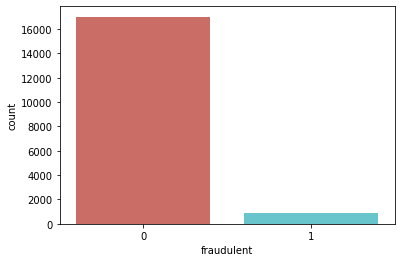

In [ ]:
sns.countplot(x='fraudulent', data=df, palette='hls')
plt.show()

In [ ]:
df['employment_type'].value_counts()

Full-time    11620
No Data       3471
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: employment_type, dtype: int64

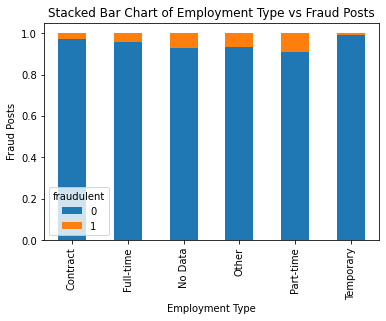

In [ ]:
table=pd.crosstab(df.employment_type, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Employment Type vs Fraud Posts')
plt.xlabel('Employment Type')
plt.ylabel('Fraud Posts')
plt.show()

In [ ]:
df['required_experience'].value_counts()

No Data             7050
Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: required_experience, dtype: int64

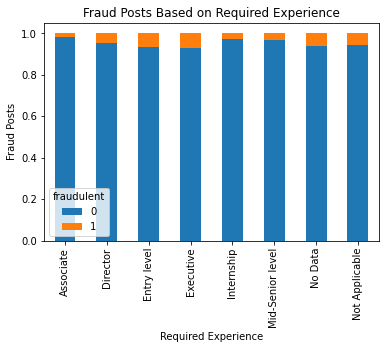

In [ ]:
%matplotlib inline

table=pd.crosstab(df.required_experience, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Fraud Posts Based on Required Experience')
plt.xlabel('Required Experience')
plt.ylabel('Fraud Posts')
plt.show()

In [ ]:
df['required_education'].value_counts()

No Data                              8105
Bachelor's Degree                    5145
High School or equivalent            2080
Unspecified                          1397
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational                             49
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: required_education, dtype: int64

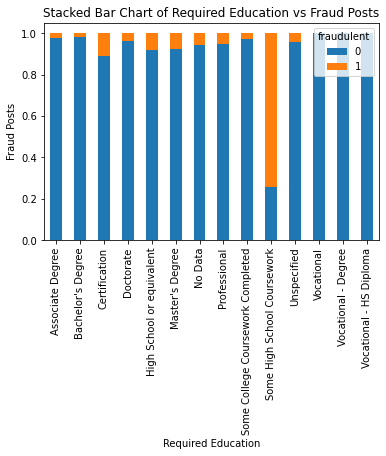

In [ ]:
table=pd.crosstab(df.required_education, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Required Education vs Fraud Posts')
plt.xlabel('Required Education')
plt.ylabel('Fraud Posts')
plt.show()

In [ ]:
df[(df['required_education'] == 'Some High School Coursework') & (df['fraudulent'] == 1)].shape[0] #20 fraud posts out of 27 total posts

20

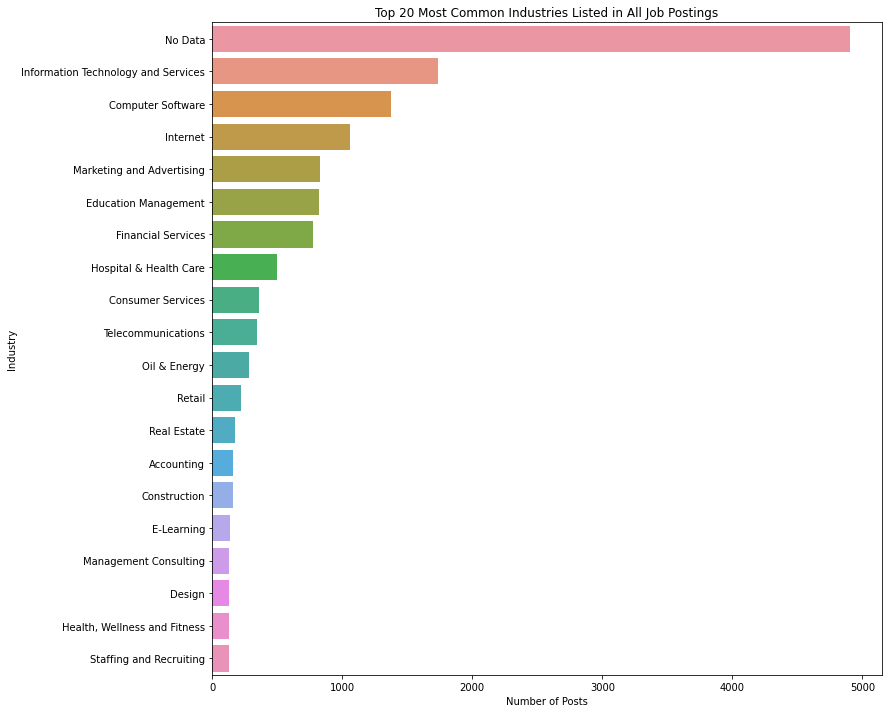

In [ ]:
#top 20 most common industries - ALL POSTS
industry=list(df['industry'])
counts = Counter(industry).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Industry', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Industry', x='Number of Posts', ax=ax, data=counts_df)
plt.title("Top 20 Most Common Industries Listed in All Job Postings")
plt.show()
#top 5: no data, information technology&services, computer software, internet, education management

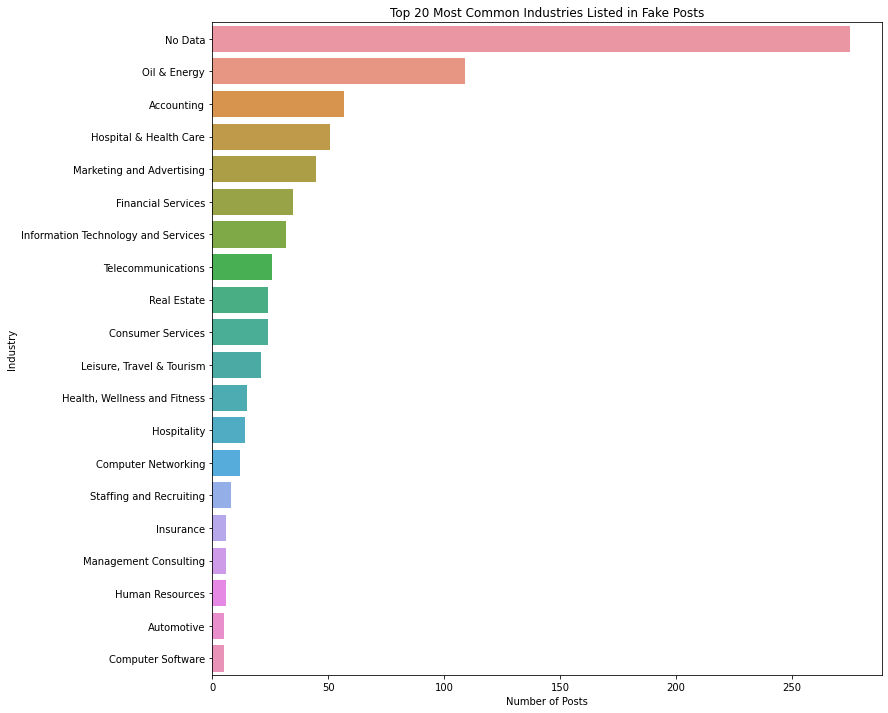

In [ ]:
#top 20 most common industries - FRAUD POSTS
industry=list(fraud_df['industry'])
counts = Counter(industry).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Industry', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Industry', x='Number of Posts', ax=ax, data=counts_df)
plt.title("Top 20 Most Common Industries Listed in Fake Posts")
plt.show()
#top 5: no data, oil&energy, accounting, hospital&health care, marketing&advertising

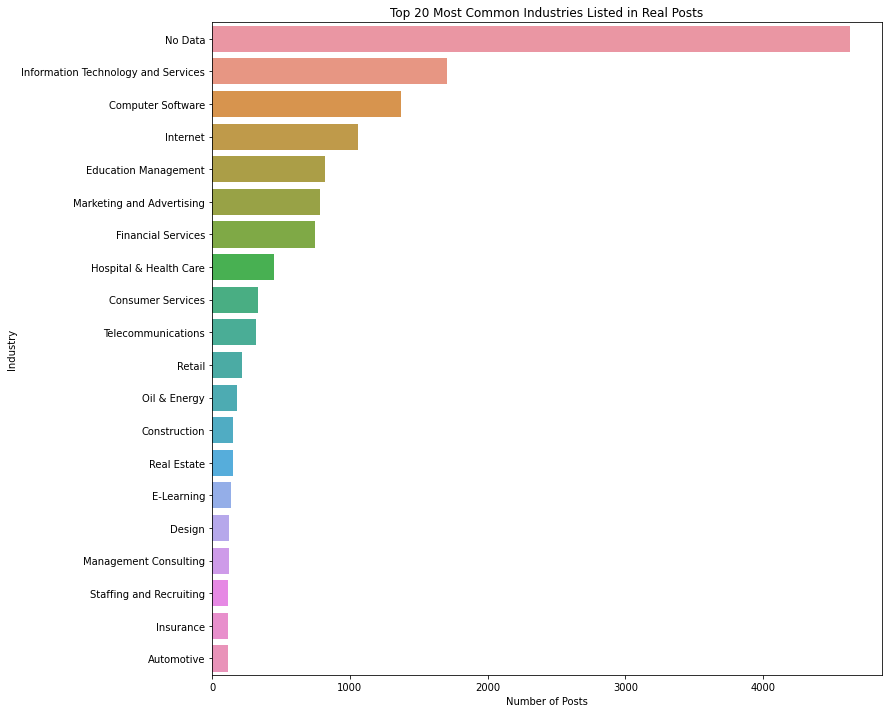

In [ ]:
#top 20 most common industries - REAL POSTS
industry=list(real_df['industry'])
counts = Counter(industry).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Industry', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Industry', x='Number of Posts', ax=ax, data=counts_df)
plt.title("Top 20 Most Common Industries Listed in Real Posts")
plt.show()
#top 5: no data, information technology&services, computer software, internet, education management

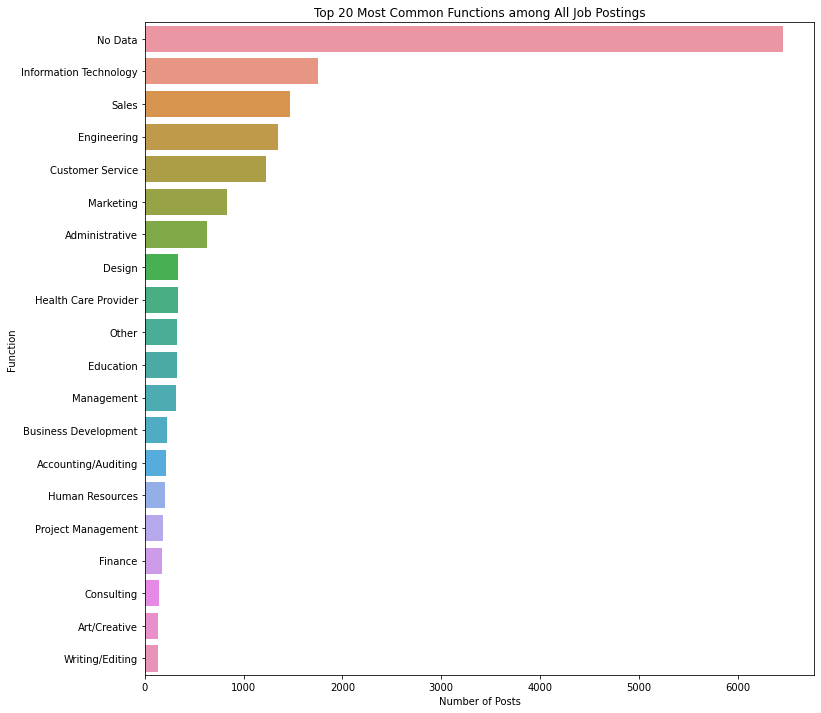

In [ ]:
#top 20 most common functions in ALL JOB POSTINGS
function=list(df['function'])
counts = Counter(function).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Function', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Function', x='Number of Posts', ax=ax, data=counts_df)
plt.title('Top 20 Most Common Functions among All Job Postings')
plt.show()
#top 5 = no data, administrative, engineering, customer service, sales

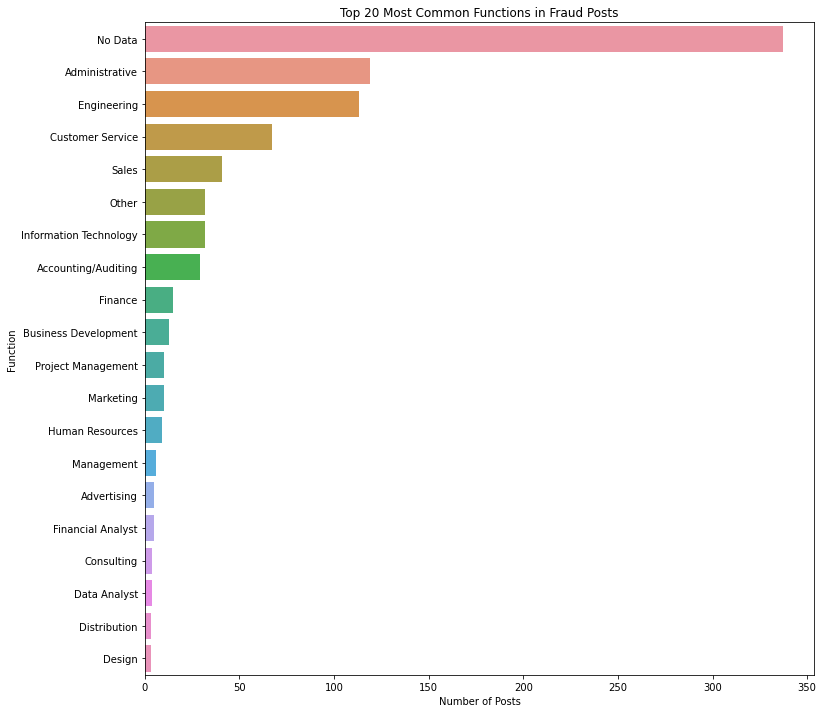

In [ ]:
#top 20 most common functions in fraud posts
function=list(fraud_df['function'])
counts = Counter(function).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Function', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Function', x='Number of Posts', ax=ax, data=counts_df)
plt.title('Top 20 Most Common Functions in Fraud Posts')
plt.show()
#top 5 = no data, administrative, engineering, customer service, sales

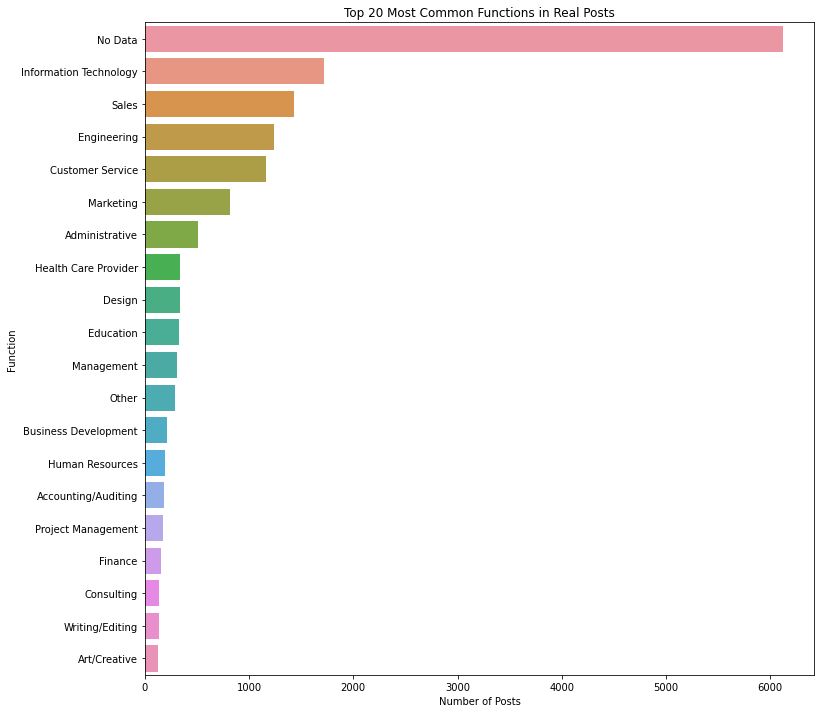

In [ ]:
#top 20 most common functions in real posts
function=list(real_df['function'])
counts = Counter(function).most_common(20)
counts_df = pd.DataFrame(counts)
counts_df.columns=['Function', 'Number of Posts']
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.barplot(y='Function', x='Number of Posts', ax=ax, data=counts_df)
plt.title('Top 20 Most Common Functions in Real Posts')
plt.show()
#top 5 = no data, information technology, sales, engineering, customer service

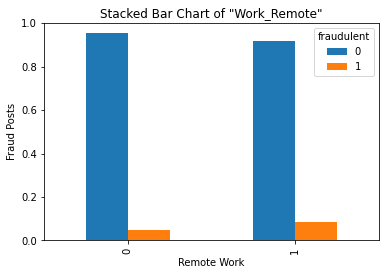

In [ ]:
table=pd.crosstab(df.work_remote, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Stacked Bar Chart of "Work_Remote"')
plt.xlabel('Remote Work')
plt.ylabel('Fraud Posts')
plt.show()

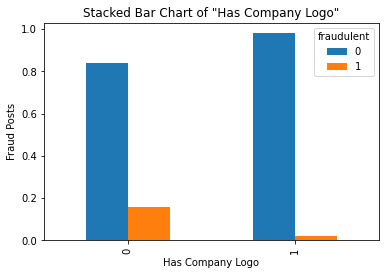

In [ ]:
table=pd.crosstab(df.has_company_logo, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Stacked Bar Chart of "Has Company Logo"')
plt.xlabel('Has Company Logo')
plt.ylabel('Fraud Posts')
plt.show()

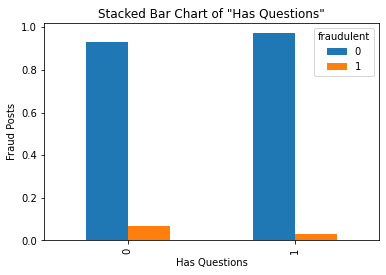

In [ ]:
table=pd.crosstab(df.has_questions, df.fraudulent)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar')
plt.title('Stacked Bar Chart of "Has Questions"')
plt.xlabel('Has Questions')
plt.ylabel('Fraud Posts')
plt.show()

## One-Hot Encode Categorical Variables

In [ ]:
print("Shape before one-hot-encoding:", df.shape)

Shape before one-hot-encoding: (17880, 12)


In [ ]:
df = pd.get_dummies(df, columns=['employment_type', 'required_experience', 'required_education', 'industry', 'function']) #categorical_cols = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
print('Shape after one-hot-encoding:',df.shape) #(17880, 205)
df.head(1) 

Shape after one-hot-encoding: (17880, 205)


,full_text,work_remote,has_company_logo,has_questions,salary_low,salary_high,fraudulent,employment_type_Contract,employment_type_Full-time,employment_type_No Data,employment_type_Other,employment_type_Part-time,employment_type_Temporary,required_experience_Associate,required_experience_Director,required_experience_Entry level,required_experience_Executive,required_experience_Internship,required_experience_Mid-Senior level,required_experience_No Data,required_experience_Not Applicable,required_education_Associate Degree,required_education_Bachelor's Degree,required_education_Certification,required_education_Doctorate,required_education_High School or equivalent,required_education_Master's Degree,required_education_No Data,required_education_Professional,required_education_Some College Coursework Completed,required_education_Some High School Coursework,required_education_Unspecified,required_education_Vocational,required_education_Vocational - Degree,required_education_Vocational - HS Diploma,industry_Accounting,industry_Airlines/Aviation,industry_Alternative Dispute Resolution,industry_Animation,industry_Apparel & Fashion,...,industry_Wireless,industry_Writing and Editing,function_Accounting/Auditing,function_Administrative,function_Advertising,function_Art/Creative,function_Business Analyst,function_Business Development,function_Consulting,function_Customer Service,function_Data Analyst,function_Design,function_Distribution,function_Education,function_Engineering,function_Finance,function_Financial Analyst,function_General Business,function_Health Care Provider,function_Human Resources,function_Information Technology,function_Legal,function_Management,function_Manufacturing,function_Marketing,function_No Data,function_Other,function_Product Management,function_Production,function_Project Management,function_Public Relations,function_Purchasing,function_Quality Assurance,function_Research,function_Sales,function_Science,function_Strategy/Planning,function_Supply Chain,function_Training,function_Writing/Editing
0,"Marketing Intern USA, NY, New York Marketing W...",0,1,0,18826,335284,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Split Data into Train, Val, and Test Sets

The data had already been split to get the salary mean for the training set, but now I will re-split it again (random_state = 1 will ensure that results were same as before) now that there are no NA values. 

In [ ]:
print('dataframe shape:',df.shape)
train, test_x = train_test_split(df, train_size=0.8, random_state=1, shuffle=True, stratify=df.fraudulent.values)
# print("train shape:",train.shape)

train_x, val_x= train_test_split(train, train_size = 0.8, random_state=1, shuffle = True, stratify=train.fraudulent.values)
print("train_x shape:",train_x.shape)
print('val shape:',val_x.shape)
print('test shape:',test_x.shape)

dataframe shape: (17880, 205)
train_x shape: (11443, 205)
val shape: (2861, 205)
test shape: (3576, 205)


In [ ]:
train_x.nunique() #can't see all unique values so going to break it down into 5 sets of 41 columns

full_text                     11281
work_remote                       2
has_company_logo                  2
has_questions                     2
salary_low                      206
                              ...  
function_Science                  2
function_Strategy/Planning        2
function_Supply Chain             2
function_Training                 2
function_Writing/Editing          2
Length: 205, dtype: int64

In [ ]:
train_x.nunique()[:41]

full_text                                               11281
work_remote                                                 2
has_company_logo                                            2
has_questions                                               2
salary_low                                                206
salary_high                                               229
fraudulent                                                  2
employment_type_Contract                                    2
employment_type_Full-time                                   2
employment_type_No Data                                     2
employment_type_Other                                       2
employment_type_Part-time                                   2
employment_type_Temporary                                   2
required_experience_Associate                               2
required_experience_Director                                2
required_experience_Entry level                             2
required

In [ ]:
train_x.nunique()[41:82]

industry_Automotive                             2
industry_Aviation & Aerospace                   2
industry_Banking                                2
industry_Biotechnology                          2
industry_Broadcast Media                        2
industry_Building Materials                     2
industry_Business Supplies and Equipment        2
industry_Capital Markets                        2
industry_Chemicals                              2
industry_Civic & Social Organization            2
industry_Civil Engineering                      2
industry_Commercial Real Estate                 2
industry_Computer & Network Security            2
industry_Computer Games                         2
industry_Computer Hardware                      2
industry_Computer Networking                    2
industry_Computer Software                      2
industry_Construction                           2
industry_Consumer Electronics                   2
industry_Consumer Goods                         2


In [ ]:
train_x.nunique()[82:123]

industry_Government Relations                    2
industry_Graphic Design                          2
industry_Health, Wellness and Fitness            2
industry_Higher Education                        2
industry_Hospital & Health Care                  2
industry_Hospitality                             2
industry_Human Resources                         2
industry_Import and Export                       2
industry_Individual & Family Services            2
industry_Industrial Automation                   2
industry_Information Services                    2
industry_Information Technology and Services     2
industry_Insurance                               2
industry_International Trade and Development     2
industry_Internet                                2
industry_Investment Banking                      2
industry_Investment Management                   2
industry_Law Enforcement                         2
industry_Law Practice                            2
industry_Legal Services        

In [ ]:
train_x.nunique()[123:164]

industry_Nonprofit Organization Management      2
industry_Oil & Energy                           2
industry_Online Media                           2
industry_Outsourcing/Offshoring                 2
industry_Package/Freight Delivery               1
industry_Packaging and Containers               2
industry_Performing Arts                        2
industry_Pharmaceuticals                        2
industry_Philanthropy                           2
industry_Photography                            2
industry_Plastics                               2
industry_Primary/Secondary Education            2
industry_Printing                               2
industry_Professional Training & Coaching       2
industry_Program Development                    2
industry_Public Policy                          2
industry_Public Relations and Communications    2
industry_Public Safety                          2
industry_Publishing                             2
industry_Ranching                               2


In [ ]:
train_x.nunique()[164:]

industry_Wine and Spirits          1
industry_Wireless                  2
industry_Writing and Editing       2
function_Accounting/Auditing       2
function_Administrative            2
function_Advertising               2
function_Art/Creative              2
function_Business Analyst          2
function_Business Development      2
function_Consulting                2
function_Customer Service          2
function_Data Analyst              2
function_Design                    2
function_Distribution              2
function_Education                 2
function_Engineering               2
function_Finance                   2
function_Financial Analyst         2
function_General Business          2
function_Health Care Provider      2
function_Human Resources           2
function_Information Technology    2
function_Legal                     2
function_Management                2
function_Manufacturing             2
function_Marketing                 2
function_No Data                   2
f

There are 5 industries where the training data only has 1 option: 
* industry_Libraries
* industry_Military 
* industry_Package/Freight Delivery
* industry_Shipbuilding 
* industry_Wine and Spirits

This means that the models are only learning 1 answer from the training data  for these five columns. 


In [ ]:
print('industry_Libraries')
print('Train:\n',train_x['industry_Libraries'].value_counts())
print('Val:\n', val_x['industry_Libraries'].value_counts())
print('Test:\n', test_x['industry_Libraries'].value_counts())


industry_Libraries
Train:
 0    11443
Name: industry_Libraries, dtype: int64
Val:
 0    2860
1       1
Name: industry_Libraries, dtype: int64
Test:
 0    3575
1       1
Name: industry_Libraries, dtype: int64


In [ ]:
print('industry_Military')
print('Train:\n',train_x['industry_Military'].value_counts())
print('Val:\n', val_x['industry_Military'].value_counts())
print('Test:\n', test_x['industry_Military'].value_counts())

industry_Military
Train:
 0    11443
Name: industry_Military, dtype: int64
Val:
 0    2861
Name: industry_Military, dtype: int64
Test:
 0    3574
1       2
Name: industry_Military, dtype: int64


In [ ]:
print('industry_Package/Freight Delivery')
print('Train:\n',train_x['industry_Package/Freight Delivery'].value_counts())
print('Val:\n', val_x['industry_Package/Freight Delivery'].value_counts())
print('Test:\n', test_x['industry_Package/Freight Delivery'].value_counts())

industry_Package/Freight Delivery
Train:
 0    11443
Name: industry_Package/Freight Delivery, dtype: int64
Val:
 0    2858
1       3
Name: industry_Package/Freight Delivery, dtype: int64
Test:
 0    3574
1       2
Name: industry_Package/Freight Delivery, dtype: int64


In [ ]:
print('industry_Shipbuilding')
print('Train:\n',train_x['industry_Shipbuilding'].value_counts())
print('Val:\n', val_x['industry_Shipbuilding'].value_counts())
print('Test:\n', test_x['industry_Shipbuilding'].value_counts())

industry_Shipbuilding
Train:
 0    11443
Name: industry_Shipbuilding, dtype: int64
Val:
 0    2861
Name: industry_Shipbuilding, dtype: int64
Test:
 0    3575
1       1
Name: industry_Shipbuilding, dtype: int64


In [ ]:
print('industry_Wine and Spirits')
print('Train:\n',train_x['industry_Wine and Spirits'].value_counts())
print('Val:\n', val_x['industry_Wine and Spirits'].value_counts())
print('Test:\n', test_x['industry_Wine and Spirits'].value_counts())

industry_Wine and Spirits
Train:
 0    11443
Name: industry_Wine and Spirits, dtype: int64
Val:
 0    2860
1       1
Name: industry_Wine and Spirits, dtype: int64
Test:
 0    3576
Name: industry_Wine and Spirits, dtype: int64


In [ ]:
print(val_x.nunique()[:41])
print(val_x.nunique()[41:82])
print(val_x.nunique()[82:123])
print(val_x.nunique()[123:164])
print(val_x.nunique()[164:])

full_text                                               2849
work_remote                                                2
has_company_logo                                           2
has_questions                                              2
salary_low                                               113
salary_high                                              131
fraudulent                                                 2
employment_type_Contract                                   2
employment_type_Full-time                                  2
employment_type_No Data                                    2
employment_type_Other                                      2
employment_type_Part-time                                  2
employment_type_Temporary                                  2
required_experience_Associate                              2
required_experience_Director                               2
required_experience_Entry level                            2
required_experience_Exec

In [ ]:
print(test_x.nunique()[:41])
print(test_x.nunique()[41:82])
print(test_x.nunique()[82:123])
print(test_x.nunique()[123:164])
print(test_x.nunique()[164:])

full_text                                               3564
work_remote                                                2
has_company_logo                                           2
has_questions                                              2
salary_low                                               137
salary_high                                              152
fraudulent                                                 2
employment_type_Contract                                   2
employment_type_Full-time                                  2
employment_type_No Data                                    2
employment_type_Other                                      2
employment_type_Part-time                                  2
employment_type_Temporary                                  2
required_experience_Associate                              2
required_experience_Director                               2
required_experience_Entry level                            2
required_experience_Exec

In [ ]:
train_x['fraudulent'].value_counts()

0    10889
1      554
Name: fraudulent, dtype: int64

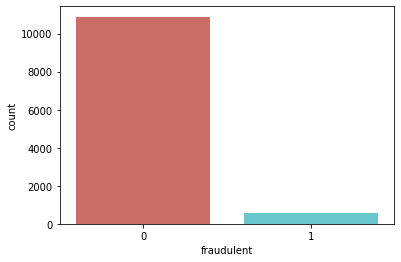

In [ ]:
sns.countplot(x='fraudulent', data=train_x, palette='hls')
plt.show()

## Reducing the Training Dataset



In [ ]:
train_x['fraudulent'].value_counts() #I will keep all 554 fraudulent posts and instead just subsample the real posts using the sample(frac=0.5, random_state=1)

0    10889
1      554
Name: fraudulent, dtype: int64

In [ ]:
def undersample_data(new_df, col_name, val, fraction, seed):
  undersampled = new_df[new_df[col_name] == val]
  undersampled=undersampled.sample(frac=fraction, random_state=seed)
  # print(undersampled.shape)
  # print(undersampled['fraudulent'].value_counts()) #making sure only real data has been subsampled
  return undersampled

In [ ]:
fake_train = train_x[train_x['fraudulent'] == 1]
fake_train.shape

(554, 205)

In [ ]:
undersampled = undersample_data(train_x, 'fraudulent', 0, 0.5, 1)
under_train_x = undersampled.append(fake_train)
under_train_x['fraudulent'].value_counts()

0    5444
1     554
Name: fraudulent, dtype: int64

In [ ]:
under_train_x_labels = under_train_x['fraudulent']

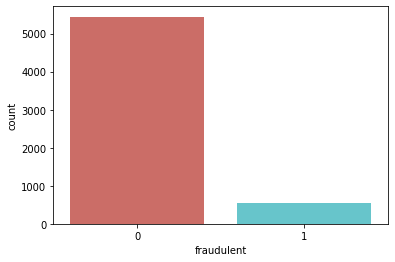

In [ ]:
sns.countplot(x='fraudulent', data=under_train_x, palette='hls') #approximately a 90/10 ratio
plt.show()

## Base Model - RNN with Embedding Layer

### Numeric + Text Inputs

#### Building the Model with Numeric and Text Data

In [ ]:
#TextVectorization layer: 
#turns raw strings into an encoded representation that can be read by an Embedding layer or Dense layer
#TextVectorization(max_tokens, standardize, split, ngrams, output_mode, output_sequence_length, pad_to_max_tokens)

def vectorize(text):
  vectorize_layer = TextVectorization(
      output_mode='int',
      max_tokens=128)
      #output_sequence_length=512 gave 125,764 total vocabulary size
  
  vectorize_layer.adapt(np.asarray(text)) #builds vocabulary
  return vectorize_layer

In [ ]:
text=train_x['full_text'].values
text[:10]

array(['Sitecore CMS Developer     Will Dom is a top notch IT Outsourcing Business Ecosystem, where each member contributes in creating world class value. With offices in Silicon Valley, Buenos Aires and Bolivia we work with the most demanding clients in the USA, Europe and Latin America. One of our clients is looking for a .NET\xa0Developer\xa0with Site Core to start immediately on a new project. This position can sit\xa0REMOTE\xa0for the right person. Experience with Site Core CMS is a must-have, and 3+ years of experience using #URL_01a736d89d2f0b19de700923d2c312837e180465650804d0f84105352812bf9a#, C#, and #URL_de16367b05c5ad8d662bcb494e7f33613767a6a8881ee57a6328b09d250602b9# are necessary.\xa0 - 2+ years of hands on experience using Sitecore CMS\xa0- 3+ years experience developing applications with #URL_01a736d89d2f0b19de700923d2c312837e180465650804d0f84105352812bf9a# using C# and #URL_de16367b05c5ad8d662bcb494e7f33613767a6a8881ee57a6328b09d250602b9#\xa0- 3+ years experience with S

In [ ]:
vocab = vectorize(text)
vocab = list(vocab.get_vocabulary())
print(f"Total Length of vocab: {len(vocab)}\nTop 20 words in vocab: {vocab[:20]}\nLast 20 words in vocab: {vocab[-20:]}")

Total Length of vocab: 128
Top 20 words in vocab: ['', '[UNK]', 'and', 'to', 'the', 'of', 'a', 'in', 'with', 'for', 'is', 'our', 'we', 'you', 'are', 'as', 'be', 'experience', 'on', 'work']
Last 20 words in vocab: ['manager', 'make', 'digital', 'if', 'do', 'training', 'process', 'companies', 'mobile', 'media', 'projects', 'get', 'part', 'over', 'social', 'full', '–', 'like', 'information', 'engineering']


In [ ]:
#Embedding Layer: 
#Turns positive integers (indexes) into dense vectors of fixed size
# This layer can only be used as the first layer in a model

# tf.keras.layers.Embedding(
#     input_dim,
#     output_dim,
#     embeddings_initializer="uniform",
#     embeddings_regularizer=None,
#     activity_regularizer=None,
#     embeddings_constraint=None,
#     mask_zero=False,
#     input_length=None,
#     **kwargs
# )

In [ ]:
train_text = train_x['full_text'].to_numpy()
val_text=val_x['full_text'].to_numpy()
test_text = test_x['full_text'].to_numpy()
undersampled_text = under_train_x['full_text'].to_numpy()

print(train_text.shape, val_text.shape, test_text.shape, undersampled_text.shape)

(11443,) (2861,) (3576,) (5998,)


In [ ]:
train_numeric = train_x.drop(['full_text', 'fraudulent'], axis=1).to_numpy()
val_numeric=val_x.drop(['full_text', 'fraudulent'], axis=1).to_numpy()
test_numeric = test_x.drop(['full_text', 'fraudulent'], axis=1).to_numpy()
undersampled_numeric = under_train_x.drop(['full_text', 'fraudulent'], axis=1).to_numpy()

print(train_numeric.shape, val_numeric.shape, test_numeric.shape, undersampled_numeric)

(11443, 203) (2861, 203) (3576, 203) [[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
train_labels = train_x['fraudulent'].to_numpy()
val_labels = val_x['fraudulent'].to_numpy()
test_labels = test_x['fraudulent'].to_numpy()
undersampled_labels = under_train_x['fraudulent'].to_numpy()

print(train_labels.shape, val_labels.shape, test_labels.shape, undersampled_labels.shape)

(11443,) (2861,) (3576,) (5998,)


In [ ]:
print('Text:',train_text[0])
print('Numeric Variables:\n',train_numeric[0])
print('Label:',train_labels[0])

Text: Sitecore CMS Developer     Will Dom is a top notch IT Outsourcing Business Ecosystem, where each member contributes in creating world class value. With offices in Silicon Valley, Buenos Aires and Bolivia we work with the most demanding clients in the USA, Europe and Latin America. One of our clients is looking for a .NET Developer with Site Core to start immediately on a new project. This position can sit REMOTE for the right person. Experience with Site Core CMS is a must-have, and 3+ years of experience using #URL_01a736d89d2f0b19de700923d2c312837e180465650804d0f84105352812bf9a#, C#, and #URL_de16367b05c5ad8d662bcb494e7f33613767a6a8881ee57a6328b09d250602b9# are necessary.  - 2+ years of hands on experience using Sitecore CMS - 3+ years experience developing applications with #URL_01a736d89d2f0b19de700923d2c312837e180465650804d0f84105352812bf9a# using C# and #URL_de16367b05c5ad8d662bcb494e7f33613767a6a8881ee57a6328b09d250602b9# - 3+ years experience with SQL/TSQL and SQL Server 

In [ ]:
metrics_list = [
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.AUC(name='auc')
  ]

def build_rnn_model():
  text_inputs=tf.keras.Input(shape=(1,), dtype=tf.string, name='text_inputs') 
  text_outputs = vectorize(text_inputs) #text_outputs.dtype = 'tf.int64'
  i = layers.Embedding(len(vectorize.get_vocabulary()), 128, input_length=128, mask_zero=True)(text_outputs) #changed from input_length=512
  i=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(i)

  numeric_inputs = tf.keras.Input(shape=(203,), name='numeric_inputs')
  j=layers.Dense(128, activation='relu', name='dense_j1', 
                kernel_initializer=tf.keras.initializers.he_normal(seed=1))(numeric_inputs)
  j=layers.Dropout(0.1)(j)
  j=layers.Dense(128, activation='relu', name='dense_j2', 
                kernel_initializer=tf.keras.initializers.he_normal(seed=1))(j) #j.dtype='float32'

  inputs = keras.layers.concatenate([i, j])
  x = layers.Dense(32, activation='relu', name='layer1')(inputs)
  # x=layers.Dropout(0.2, name='dropout1')(x)
  # x = layers.Dense(32, activation='relu', name='layer2')(x)
  # x=layers.Dropout(0.2, name='dropout2')(x)
  output=layers.Dense(1, activation='sigmoid', name='final_output')(x)

  rnn_model = Model(inputs=[text_inputs, numeric_inputs], outputs=[output])
  return rnn_model

In [ ]:
model_rnn = build_rnn_model()
print(model_rnn.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
numeric_inputs (InputLayer)     [(None, 203)]        0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, None)         0           text_inputs[0][0]                
__________________________________________________________________________________________________
dense_j1 (Dense)                (None, 128)          26112       numeric_inputs[0][0]             
____________________________________________________________________________________________

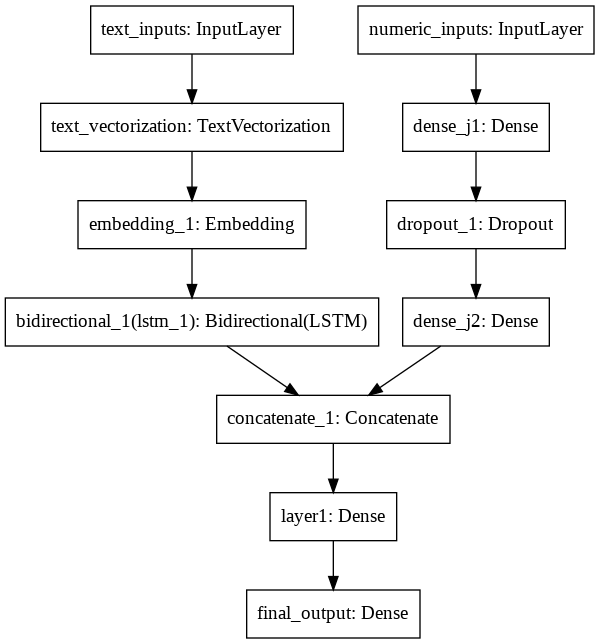

In [ ]:
keras.utils.plot_model(model_rnn)

#### Training the model with text + numeric variables

In [ ]:
from statistics import mean

In [ ]:
model_rnn.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=metrics_list)

In [ ]:
history = model_rnn.fit([train_text, train_numeric], train_labels, epochs=5, validation_data=([val_text, val_numeric], val_labels))

Epoch 1/5
358/358 [==============================] - 971s 3s/step - loss: 36818.3672 - fp: 4765.4540 - fn: 39.5265 - accuracy: 0.1297 - auc: 0.4852 - val_loss: 400.2824 - val_fp: 69.0000 - val_fn: 132.0000 - val_accuracy: 0.9297 - val_auc: 0.5139
Epoch 2/5
358/358 [==============================] - 965s 3s/step - loss: 16602.4953 - fp: 872.8635 - fn: 227.5014 - accuracy: 0.7935 - auc: 0.5034 - val_loss: 834.6539 - val_fp: 38.0000 - val_fn: 136.0000 - val_accuracy: 0.9392 - val_auc: 0.5038
Epoch 3/5
358/358 [==============================] - 961s 3s/step - loss: 1402.1974 - fp: 469.0724 - fn: 257.9582 - accuracy: 0.8701 - auc: 0.5191 - val_loss: 976.3291 - val_fp: 36.0000 - val_fn: 136.0000 - val_accuracy: 0.9399 - val_auc: 0.5040
Epoch 4/5
358/358 [==============================] - 964s 3s/step - loss: 1085.0252 - fp: 302.4847 - fn: 248.8384 - accuracy: 0.9026 - auc: 0.5057 - val_loss: 1018.0746 - val_fp: 35.0000 - val_fn: 136.0000 - val_accuracy: 0.9402 - val_auc: 0.5042
Epoch 5/5
358

In [ ]:
history.history

{'accuracy': [0.27868565917015076,
  0.8276675939559937,
  0.8808878660202026,
  0.9043956995010376,
  0.9119986295700073],
 'auc': [0.49852606654167175,
  0.5075833797454834,
  0.5079975724220276,
  0.5033439993858337,
  0.5124426484107971],
 'fn': [142.0, 472.0, 503.0, 522.0, 515.0],
 'fp': [8112.0, 1500.0, 860.0, 572.0, 492.0],
 'loss': [20572.142578125,
  5430.4716796875,
  1474.950439453125,
  1228.34814453125,
  1245.5841064453125],
 'val_accuracy': [0.9297448396682739,
  0.9391821026802063,
  0.9398811459541321,
  0.940230667591095,
  0.9486193656921387],
 'val_auc': [0.513884961605072,
  0.503811240196228,
  0.5039988160133362,
  0.5041825771331787,
  0.5053573250770569],
 'val_fn': [132.0, 136.0, 136.0, 136.0, 137.0],
 'val_fp': [69.0, 38.0, 36.0, 35.0, 10.0],
 'val_loss': [400.28240966796875,
  834.6538696289062,
  976.3291015625,
  1018.0746459960938,
  1059.6102294921875]}

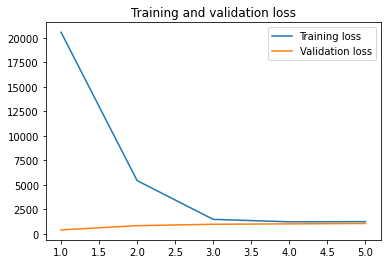

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

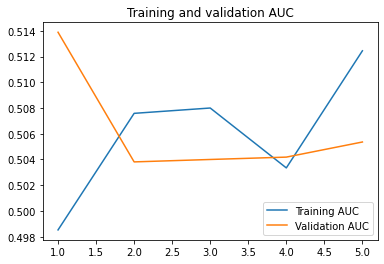

In [ ]:
auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(auc) + 1)
plt.figure()
plt.plot(epochs, auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.title('Training and validation AUC')
plt.legend()
plt.show()

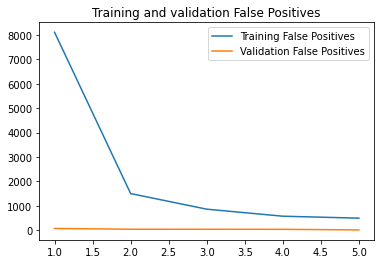

In [ ]:
fp = history.history['fp']
val_fp = history.history['val_fp']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, fp, label='Training False Positives')
plt.plot(epochs, val_fp, label='Validation False Positives')
plt.title('Training and validation False Positives')
plt.legend()
plt.show()

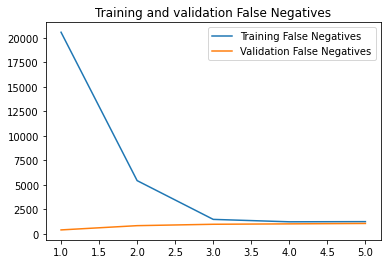

In [ ]:
fn = history.history['fn']
val_fn = history.history['val_fn']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training False Negatives')
plt.plot(epochs, val_loss, label='Validation False Negatives')
plt.title('Training and validation False Negatives')
plt.legend()
plt.show()

#### Comparing these results with training the model on undersampled training data (validation data remains the same)

In [ ]:
model_rnn.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=metrics_list)

In [ ]:
history = model_rnn.fit([undersampled_text, undersampled_numeric], undersampled_labels, epochs=5, validation_data=([val_text, val_numeric], val_labels))

Epoch 1/5
188/188 [==============================] - 561s 3s/step - loss: 31838.5766 - fp: 2554.7513 - fn: 24.8466 - accuracy: 0.1332 - auc: 0.4859 - val_loss: 317.9242 - val_fp: 5.0000 - val_fn: 139.0000 - val_accuracy: 0.9497 - val_auc: 0.5007
Epoch 2/5
188/188 [==============================] - 564s 3s/step - loss: 2751.4449 - fp: 623.8624 - fn: 222.9206 - accuracy: 0.6929 - auc: 0.4685 - val_loss: 849.0920 - val_fp: 1.0000 - val_fn: 139.0000 - val_accuracy: 0.9511 - val_auc: 0.5010
Epoch 3/5
188/188 [==============================] - 564s 3s/step - loss: 1854.9827 - fp: 281.2751 - fn: 252.4074 - accuracy: 0.8255 - auc: 0.5096 - val_loss: 890.5968 - val_fp: 0.0000e+00 - val_fn: 139.0000 - val_accuracy: 0.9514 - val_auc: 0.5010
Epoch 4/5
188/188 [==============================] - 571s 3s/step - loss: 1492.5894 - fp: 225.6614 - fn: 243.1746 - accuracy: 0.8514 - auc: 0.5308 - val_loss: 848.4423 - val_fp: 0.0000e+00 - val_fn: 139.0000 - val_accuracy: 0.9514 - val_auc: 0.5010
Epoch 5/5
1

In [ ]:
history.history

{'accuracy': [0.232244074344635,
  0.7509169578552246,
  0.8261086940765381,
  0.8436145186424255,
  0.8404468297958374],
 'auc': [0.4868510365486145,
  0.4910663962364197,
  0.5047811269760132,
  0.5145382285118103,
  0.5068667531013489],
 'fn': [102.0, 468.0, 503.0, 502.0, 511.0],
 'fp': [4503.0, 1026.0, 540.0, 436.0, 446.0],
 'loss': [20363.947265625,
  2287.07958984375,
  1776.72607421875,
  1729.85009765625,
  1660.5882568359375],
 'val_accuracy': [0.9496679306030273,
  0.9510660767555237,
  0.9514155983924866,
  0.9514155983924866,
  0.9514155983924866],
 'val_auc': [0.50066077709198,
  0.5010122060775757,
  0.5010108947753906,
  0.5010108947753906,
  0.5010095834732056],
 'val_fn': [139.0, 139.0, 139.0, 139.0, 139.0],
 'val_fp': [5.0, 1.0, 0.0, 0.0, 0.0],
 'val_loss': [317.9242248535156,
  849.092041015625,
  890.5968017578125,
  848.4422607421875,
  772.0736694335938]}

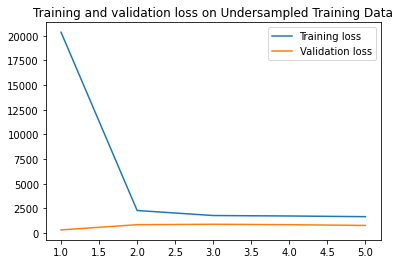

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss on Undersampled Training Data')
plt.legend()
plt.show()

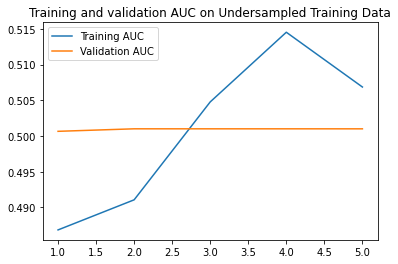

In [ ]:
auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(auc) + 1)
plt.figure()
plt.plot(epochs, auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.title('Training and validation AUC on Undersampled Training Data')
plt.legend()
plt.show()

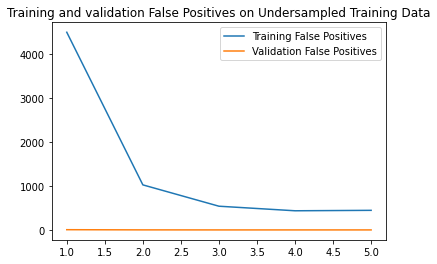

In [ ]:
fp = history.history['fp']
val_fp = history.history['val_fp']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, fp, label='Training False Positives')
plt.plot(epochs, val_fp, label='Validation False Positives')
plt.title('Training and validation False Positives on Undersampled Training Data')
plt.legend()
plt.show()

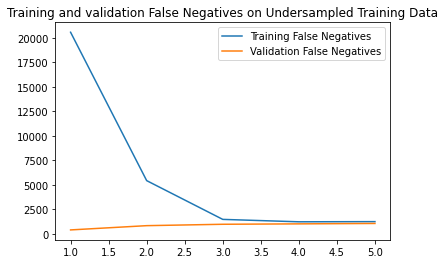

In [ ]:
fn = history.history['fn']
val_fn = history.history['val_fn']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training False Negatives')
plt.plot(epochs, val_loss, label='Validation False Negatives')
plt.title('Training and validation False Negatives on Undersampled Training Data')
plt.legend()
plt.show()

The mean undersampled validation AUC was only barely lower than the mean validation AUC for the entire dataset: 
* All Training Data: 0.5054
* Undersampled Training Data: 0.5010

That being said, an AUC of roughly 50% is not good at all. 

#### Retraining the entire model for the test set with text + numeric variables
Note: I ran this section initially but due to the low AUC values during the training phase, I know that the text-only data significantly improved the AUC so I will not rerun this section. All code was left but it has been commented out.

In [ ]:
# total_train_numeric=np.concatenate((train_numeric,val_numeric))
# total_train_text=np.concatenate((train_text,val_text))
# total_train_labels= np.concatenate((train_labels, val_labels))

# model_rnn2 = build_rnn_model()
# model_rnn2.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
#                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#                     metrics=metrics_list)
# print(model_rnn2.summary())

In [ ]:
# keras.utils.plot_model(model_rnn2)

In [ ]:
# history2 = model_rnn2.fit([total_train_text, total_train_numeric], total_train_labels, epochs=5, validation_data=([test_text, test_numeric], test_labels))

In [ ]:
# history2.history

In [ ]:
# combo_auc = history2.history['auc']
# test_auc = history2.history['val_auc']
# print(f"Train+Val Average Mean: {mean(combo_auc)}; Test Average Mean: {mean(test_auc)}")

In [ ]:
# loss2 = history2.history['loss']
# val_loss2 = history2.history['val_loss']
# epochs2 = range(1, len(loss2) + 1)
# plt.figure()
# plt.plot(epochs2, loss2, label='Training loss')
# plt.plot(epochs2, val_loss2, label='Validation loss')
# plt.title('Train+Validation and Testing loss (Text Only Data)')
# plt.legend()
# plt.show()

In [ ]:
# auc2 = history2.history['auc']
# val_auc2 = history2.history['val_auc']
# epochs2 = range(1, len(auc2) + 1)
# plt.figure()
# plt.plot(epochs2, auc2, label='Training AUC')
# plt.plot(epochs2, val_auc2, label='Validation AUC')
# plt.title('Train+Validation and Testing AUC (Text Only Data)')
# plt.legend()
# plt.show()

### Text-Only Inputs

#### Create Text-Only Data \--

In [ ]:
df_text_only = df_preproc_done.copy()
df_text_only.drop(columns=['work_remote', 'has_company_logo', 'has_questions', 'salary_low', 'salary_high'],inplace=True)
df_text_only.head(3)
df_text = df_text_only.copy()

In [ ]:
df_text.title = df_text['title'] + ' ' + df_text['location']  + ' ' + df_text['description']
df_text.department = df_text['department'] + ' ' + df_text['employment_type'] + ' ' + df_text['required_experience'] + ' ' + df_text['industry'] + ' ' + df_text['function'] + ' ' + df_text['required_education']
df_text.drop(columns=['location', 'description', 'employment_type', 'required_experience', 'industry', 'function', 'required_education'], inplace=True)

In [ ]:
#replace 'No Data' with empty space ?? 
df_text.rename(columns={'title': 'title_loc_description', 'department': 'cat_vars'}, inplace=True)
df_text.head()

,title_loc_description,cat_vars,company_profile,requirements,benefits,fraudulent,full_text
0,"Marketing Intern USA, NY, New York Food52, a f...",Marketing Other Internship No Data Marketing N...,"We're Food52, and we've created a groundbreaki...",Experience with content management systems a m...,,0,"Marketing Intern USA, NY, New York Marketing W..."
1,"Customer Service - Cloud Video Production NZ, ...",Success Full-time Not Applicable Marketing and...,"90 Seconds, the worlds Cloud Video Production ...",What we expect from you:Your key responsibilit...,What you will get from us Through being part o...,0,"Customer Service - Cloud Video Production NZ, ..."
2,"Commissioning Machinery Assistant (CMA) USA, I...",No Data No Data No Data No Data No Data,Valor Services provides Workforce Solutions th...,Implement pre-commissioning and commissioning ...,,0,"Commissioning Machinery Assistant (CMA) USA, I..."
3,"Account Executive - Washington DC USA, DC, Was...",Sales Full-time Mid-Senior level Computer Soft...,Our passion for improving quality of life thro...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,"Account Executive - Washington DC USA, DC, Was..."
4,"Bill Review Manager USA, FL, Fort Worth JOB TI...",Full-time Mid-Senior level Hospital & Health...,Spot Source Solutions LLC is a Global Human Ca...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,"Bill Review Manager USA, FL, Fort Worth Spot..."


In [ ]:
#RECREATE TRAIN/VAL/TEST SPLIT WITH TEXT-ONLY DATA

print('dataframe shape:',df_text.shape)
train2, test_t = train_test_split(df_text, train_size=0.8, random_state=1, shuffle=True, stratify=df_text.fraudulent.values)
# print("train shape:",train.shape)

train_t, val_t= train_test_split(train2, train_size = 0.8, random_state=1, shuffle = True, stratify=train2.fraudulent.values)
print("train_t shape:",train_t.shape)
print('val_t shape:',val_t.shape)
print('test_t shape:',test_t.shape)

dataframe shape: (17880, 7)
train_t shape: (11443, 7)
val_t shape: (2861, 7)
test_t shape: (3576, 7)


In [ ]:
text_combos = df_text.columns[:-2] #removes full_text and fraudulent columns
text_combos

Index(['title_loc_description', 'cat_vars', 'company_profile', 'requirements',
       'benefits'],
      dtype='object')

In [ ]:
#title_loc_description,	cat_vars,	company_profile,	requirements,	benefits
train_text1 = train_t['title_loc_description'].to_numpy()
train_text2 = train_t['cat_vars'].to_numpy()
train_text3 = train_t['company_profile'].to_numpy()
train_text4 = train_t['requirements'].to_numpy()
train_text5 = train_t['benefits'].to_numpy()
train_labels = train_t['fraudulent'].to_numpy()

val_text1 = val_t['title_loc_description'].to_numpy()
val_text2 = val_t['cat_vars'].to_numpy()
val_text3 = val_t['company_profile'].to_numpy()
val_text4 = val_t['requirements'].to_numpy()
val_text5 = val_t['benefits'].to_numpy()
val_labels = val_t['fraudulent'].to_numpy()

test_text1 = test_t['title_loc_description'].to_numpy()
test_text2 = test_t['cat_vars'].to_numpy()
test_text3 = test_t['company_profile'].to_numpy()
test_text4 = test_t['requirements'].to_numpy()
test_text5 = test_t['benefits'].to_numpy()
test_labels = test_t['fraudulent'].to_numpy()

#### Building Text-Only RNN Model


In [ ]:
text = df_text['title_loc_description'].values
vectorize1=vectorize(text)

text = df_text['cat_vars'].values
vectorize2=vectorize(text)

text = df_text['company_profile'].values
vectorize3=vectorize(text)

text = df_text['requirements'].values
vectorize4=vectorize(text)

text = df_text['benefits'].values
vectorize5=vectorize(text)


In [ ]:
vects = [vectorize1, vectorize2, vectorize3, vectorize4, vectorize5]
for v in vects:
  vocab = v.get_vocabulary()
  print(f"Total Length of vocab: {len(vocab)}\nTop 20 words in vocab: {vocab[:20]}\nLast 20 words in vocab: {vocab[-20:]}\n")

Total Length of vocab: 128
Top 20 words in vocab: ['', '[UNK]', 'and', 'the', 'to', 'of', 'a', 'in', 'for', 'with', 'our', 'is', 'you', 'are', 'will', 'be', 'as', 'we', 'on', 'team']
Last 20 words in vocab: ['media', 'into', 'growing', 'knowledge', 'engineer', 'build', 'systems', 'required', 'office', 'information', 'if', 'has', 'training', 'one', 'lead', 'social', 'do', 'communication', 'ca', 'years']

Total Length of vocab: 128
Top 20 words in vocab: ['', '[UNK]', 'data', 'no', 'fulltime', 'level', 'degree', 'bachelors', 'midsenior', 'technology', 'information', 'services', 'and', 'entry', 'associate', 'marketing', 'sales', 'or', 'school', 'high']
Last 20 words in vocab: ['security', 'building', 'materials', 'general', 'communications', 'travel', 'nonprofit', 'tourism', 'leisure', 'social', 'entertainment', 'electricalelectronic', 'client', 'beverages', 'support', 'goods', 'creative', 'team', 'cosmetics', 'vocational']

Total Length of vocab: 128
Top 20 words in vocab: ['', '[UNK]', 

In [ ]:
metrics_list = [
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.AUC(name='auc')
  ]

def build_text_rnn():
  inputs1=tf.keras.Input(shape=(1,), dtype=tf.string, name='inputs1') 
  outputs1 = vectorize1(inputs1) #text_outputs.dtype = 'tf.int64'
  a = layers.Embedding(len(vectorize1.get_vocabulary()), 128, input_length=128, mask_zero=True)(outputs1)
  a=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(a)
  
  inputs2=tf.keras.Input(shape=(1,), dtype=tf.string, name='inputs2') 
  outputs2 = vectorize2(inputs2) #text_outputs.dtype = 'tf.int64'
  b = layers.Embedding(len(vectorize2.get_vocabulary()), 128, input_length=128, mask_zero=True)(outputs2)
  b=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(b)

  inputs3=tf.keras.Input(shape=(1,), dtype=tf.string, name='inputs3') 
  outputs3 = vectorize3(inputs3) #text_outputs.dtype = 'tf.int64'
  c = layers.Embedding(len(vectorize3.get_vocabulary()), 128, input_length=128, mask_zero=True)(outputs3)
  c=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(c)

  inputs4=tf.keras.Input(shape=(1,), dtype=tf.string, name='inputs4') 
  outputs4 = vectorize4(inputs4) #text_outputs.dtype = 'tf.int64'
  d = layers.Embedding(len(vectorize4.get_vocabulary()), 128, input_length=128, mask_zero=True)(outputs4)
  d=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(d)

  inputs5=tf.keras.Input(shape=(1,), dtype=tf.string, name='inputs5') 
  outputs5 = vectorize5(inputs5) #text_outputs.dtype = 'tf.int64'
  e = layers.Embedding(len(vectorize5.get_vocabulary()), 128, input_length=128, mask_zero=True)(outputs5)
  e=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128))(e)
  
  
  inputs = keras.layers.concatenate([a,b,c,d,e])
  x = layers.Dense(32, activation='relu', name='layer1')(inputs)
  # x=layers.Dropout(0.2, name='dropout1')(x)
  # x = layers.Dense(32, activation='relu', name='layer2')(x)
  # x=layers.Dropout(0.2, name='dropout2')(x)
  output=layers.Dense(1, activation='sigmoid', name='final_output')(x)

  rnn_model = Model(inputs=[inputs1, inputs2, inputs3, inputs4, inputs5], outputs=[output])
  return rnn_model

model_rnn = build_text_rnn()
print(model_rnn.summary())
model_rnn.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=metrics_list) 

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
inputs2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
inputs3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
inputs4 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

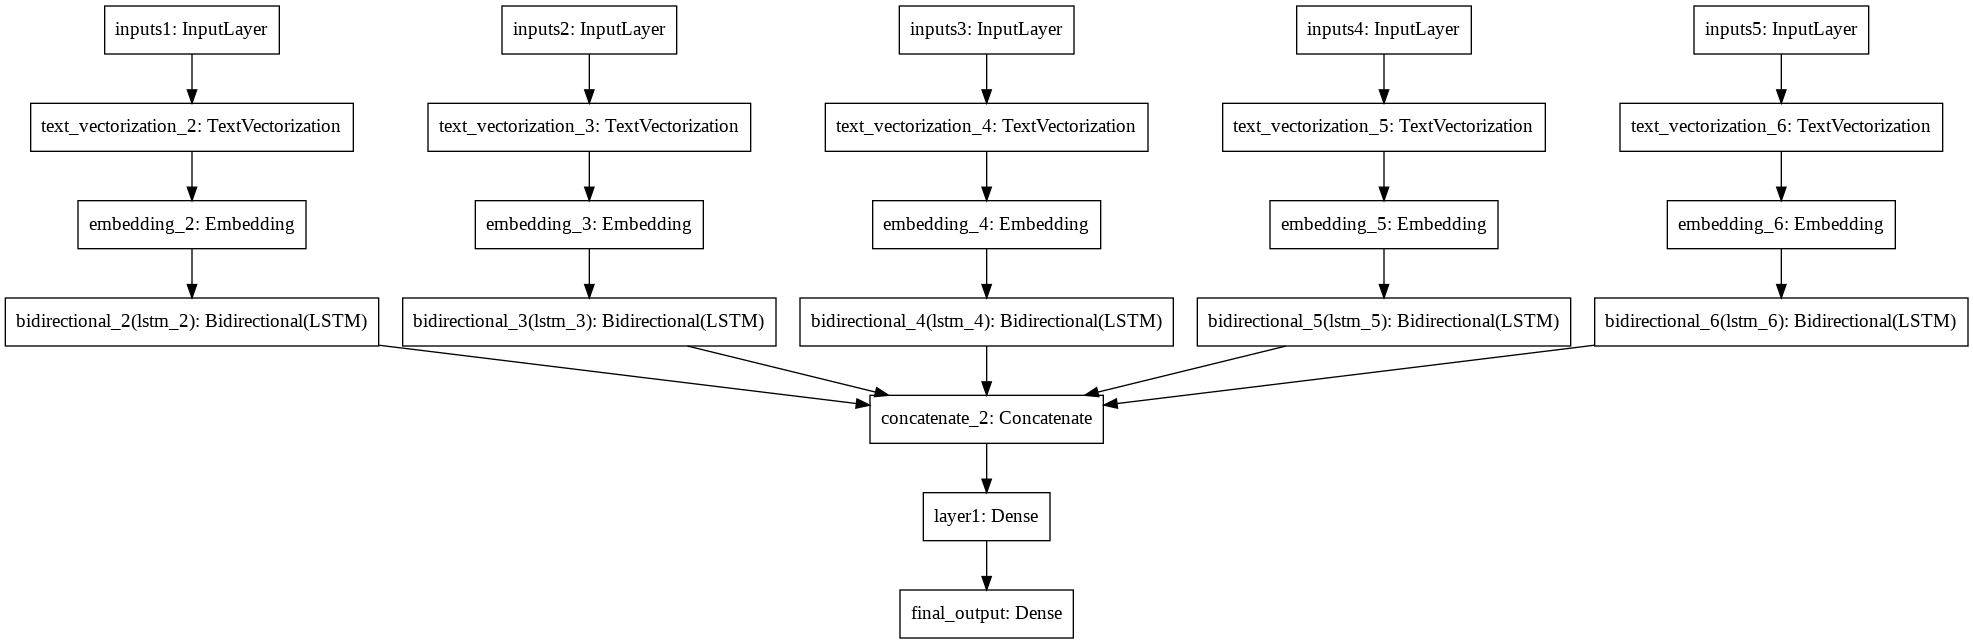

In [ ]:
keras.utils.plot_model(model_rnn)

#### Training the Text-Only Model

In [ ]:
history = model_rnn.fit([train_text1, train_text2,train_text3,train_text4,train_text5], train_labels, epochs=5, validation_data=([val_text1, val_text2,val_text3,val_text4,val_text5], val_labels))

Epoch 1/5
358/358 [==============================] - 1560s 4s/step - loss: 0.6431 - fp: 346.3928 - fn: 256.0111 - accuracy: 0.8289 - auc: 0.5637 - val_loss: 0.1908 - val_fp: 0.0000e+00 - val_fn: 139.0000 - val_accuracy: 0.9514 - val_auc: 0.7507
Epoch 2/5
358/358 [==============================] - 1517s 4s/step - loss: 0.1729 - fp: 0.0000e+00 - fn: 272.9025 - accuracy: 0.9534 - auc: 0.7573 - val_loss: 0.1719 - val_fp: 0.0000e+00 - val_fn: 139.0000 - val_accuracy: 0.9514 - val_auc: 0.7596
Epoch 3/5
358/358 [==============================] - 1520s 4s/step - loss: 0.1825 - fp: 0.0000e+00 - fn: 285.4373 - accuracy: 0.9484 - auc: 0.7540 - val_loss: 0.1691 - val_fp: 0.0000e+00 - val_fn: 139.0000 - val_accuracy: 0.9514 - val_auc: 0.7730
Epoch 4/5
358/358 [==============================] - 1515s 4s/step - loss: 0.1726 - fp: 0.0000e+00 - fn: 282.2869 - accuracy: 0.9503 - auc: 0.7808 - val_loss: 0.1664 - val_fp: 0.0000e+00 - val_fn: 139.0000 - val_accuracy: 0.9514 - val_auc: 0.7874
Epoch 5/5
358/

In [ ]:
history.history

{'accuracy': [0.9219610095024109,
  0.951586127281189,
  0.951586127281189,
  0.951586127281189,
  0.951586127281189],
 'auc': [0.541814923286438,
  0.7485669851303101,
  0.7663188576698303,
  0.7793223857879639,
  0.7929664850234985],
 'fn': [540.0, 554.0, 554.0, 554.0, 554.0],
 'fp': [353.0, 0.0, 0.0, 0.0, 0.0],
 'loss': [0.5498140454292297,
  0.175401508808136,
  0.17147603631019592,
  0.16907119750976562,
  0.1666714996099472],
 'val_accuracy': [0.9514155983924866,
  0.9514155983924866,
  0.9514155983924866,
  0.9514155983924866,
  0.9514155983924866],
 'val_auc': [0.7506832480430603,
  0.759574294090271,
  0.7730152606964111,
  0.7874327898025513,
  0.7972357273101807],
 'val_fn': [139.0, 139.0, 139.0, 139.0, 139.0],
 'val_fp': [0.0, 0.0, 0.0, 0.0, 0.0],
 'val_loss': [0.19082000851631165,
  0.1719394326210022,
  0.16908666491508484,
  0.1664351224899292,
  0.1639731079339981]}

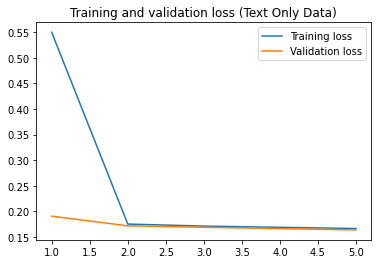

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss (Text Only Data)')
plt.legend()
plt.show()

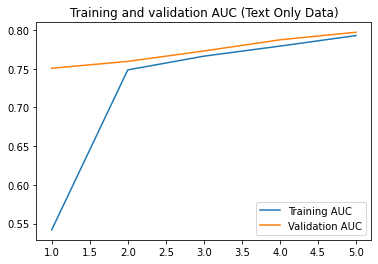

In [ ]:
auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(auc) + 1)
plt.figure()
plt.plot(epochs, auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.title('Training and validation AUC (Text Only Data)')
plt.legend()
plt.show()

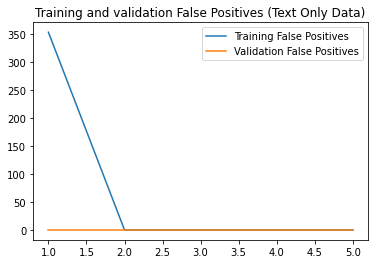

In [ ]:
fp = history.history['fp']
val_fp = history.history['val_fp']
epochs = range(1, len(fp) + 1)
plt.figure()
plt.plot(epochs, fp, label='Training False Positives')
plt.plot(epochs, val_fp, label='Validation False Positives')
plt.title('Training and validation False Positives (Text Only Data)')
plt.legend()
plt.show()

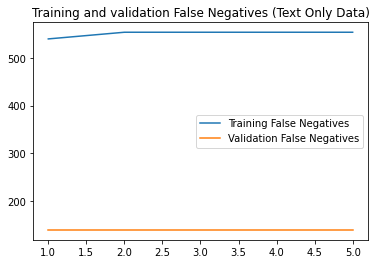

In [ ]:
fn = history.history['fn']
val_fn = history.history['val_fn']
epochs = range(1, len(fn) + 1)
plt.figure()
plt.plot(epochs, fn, label='Training False Negatives')
plt.plot(epochs,  val_fn, label='Validation False Negatives')
plt.title('Training and validation False Negatives (Text Only Data)')
plt.legend()
plt.show()

#### Applying RNN on Test Set (Text-Only)

In [ ]:
all_text1=np.concatenate((train_text1, val_text1))
all_text2=np.concatenate((train_text2, val_text2))
all_text3=np.concatenate((train_text3, val_text3))
all_text4=np.concatenate((train_text4, val_text4))
all_text5=np.concatenate((train_text5, val_text5))

all_labels= np.concatenate((train_labels, val_labels))

model_rnn2 = build_text_rnn()
model_rnn2.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
                    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    metrics=metrics_list)
print(model_rnn2.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
inputs2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
inputs3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
inputs4 (InputLayer)            [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
history2 = model_rnn2.fit([all_text1, all_text2, all_text3, all_text4, all_text5], all_labels, epochs=5, validation_data=([test_text1, test_text2, test_text3, test_text4, test_text5], test_labels))

Epoch 1/5
447/447 [==============================] - 1933s 4s/step - loss: 0.5857 - fp: 88.0982 - fn: 473.7009 - accuracy: 0.9421 - auc: 0.5755 - val_loss: 0.1844 - val_fp: 0.0000e+00 - val_fn: 173.0000 - val_accuracy: 0.9516 - val_auc: 0.6891
Epoch 2/5
447/447 [==============================] - 1900s 4s/step - loss: 0.1716 - fp: 0.0000e+00 - fn: 334.9420 - accuracy: 0.9540 - auc: 0.7230 - val_loss: 0.1777 - val_fp: 0.0000e+00 - val_fn: 173.0000 - val_accuracy: 0.9516 - val_auc: 0.7413
Epoch 3/5
447/447 [==============================] - 1896s 4s/step - loss: 0.1624 - fp: 0.0000e+00 - fn: 339.0513 - accuracy: 0.9554 - auc: 0.7642 - val_loss: 0.1751 - val_fp: 0.0000e+00 - val_fn: 173.0000 - val_accuracy: 0.9516 - val_auc: 0.7562
Epoch 4/5
447/447 [==============================] - 1884s 4s/step - loss: 0.1654 - fp: 0.0000e+00 - fn: 344.4509 - accuracy: 0.9531 - auc: 0.7782 - val_loss: 0.1723 - val_fp: 0.0000e+00 - val_fn: 173.0000 - val_accuracy: 0.9516 - val_auc: 0.7688
Epoch 5/5
447/4

In [ ]:
history2.history

{'accuracy': [0.9466356039047241,
  0.9515520334243774,
  0.9515520334243774,
  0.9515520334243774,
  0.9515520334243774],
 'auc': [0.5479598045349121,
  0.7467472553253174,
  0.774736762046814,
  0.7877886295318604,
  0.8008947372436523],
 'fn': [827.0, 693.0, 693.0, 693.0, 693.0],
 'fp': [89.0, 0.0, 0.0, 0.0, 0.0],
 'loss': [0.44193241000175476,
  0.17403586208820343,
  0.16990485787391663,
  0.16716988384723663,
  0.1641944795846939],
 'val_accuracy': [0.951621949672699,
  0.951621949672699,
  0.951621949672699,
  0.951621949672699,
  0.951621949672699],
 'val_auc': [0.6890554428100586,
  0.7412552237510681,
  0.756209671497345,
  0.768819272518158,
  0.7864303588867188],
 'val_fn': [173.0, 173.0, 173.0, 173.0, 173.0],
 'val_fp': [0.0, 0.0, 0.0, 0.0, 0.0],
 'val_loss': [0.184396430850029,
  0.1776949167251587,
  0.17506705224514008,
  0.17232973873615265,
  0.1695476472377777]}

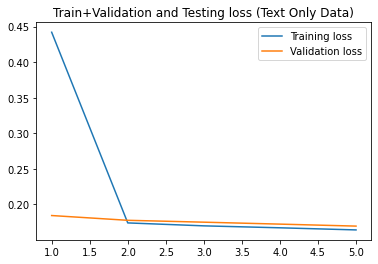

In [ ]:
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs2 = range(1, len(loss2) + 1)
plt.figure()
plt.plot(epochs2, loss2, label='Training loss')
plt.plot(epochs2, val_loss2, label='Validation loss')
plt.title('Train+Validation and Testing loss (Text Only Data)')
plt.legend()
plt.show()

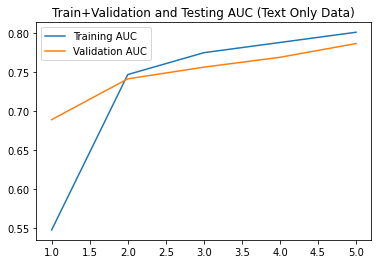

In [ ]:
auc2 = history2.history['auc']
val_auc2 = history2.history['val_auc']
epochs2 = range(1, len(auc2) + 1)
plt.figure()
plt.plot(epochs2, auc2, label='Training AUC')
plt.plot(epochs2, val_auc2, label='Validation AUC')
plt.title('Train+Validation and Testing AUC (Text Only Data)')
plt.legend()
plt.show()

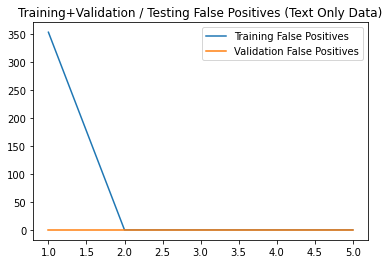

In [ ]:
fp2 = history.history['fp']
val_fp2 = history.history['val_fp']
epochs = range(1, len(fp2) + 1)
plt.figure()
plt.plot(epochs, fp2, label='Training False Positives')
plt.plot(epochs, val_fp2, label='Validation False Positives')
plt.title('Training+Validation / Testing False Positives (Text Only Data)')
plt.legend()
plt.show()

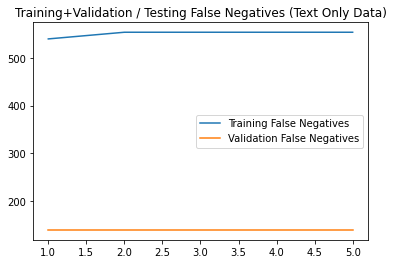

In [ ]:
fn2 = history.history['fn']
val_fn2 = history.history['val_fn']
epochs = range(1, len(fn2) + 1)
plt.figure()
plt.plot(epochs, fn2, label='Training False Negatives')
plt.plot(epochs,  val_fn2, label='Validation False Negatives')
plt.title('Training+Validation / Testing False Negatives (Text Only Data)')
plt.legend()
plt.show()

## Model with BERT  

### Installing Dependencies & Exploring BERT \--

In [ ]:
#BERT dependencies
!pip install -q tensorflow-text
!pip install -q tf-models-official

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text # A dependency of the preprocessing model
from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR') #filters out all messages

In [ ]:
# classic_bert_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4' #bert_en_uncased_L-12_H-768_A-12
small_bert_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2' ##considered small bert
# small_bert2_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2' #considered tiny bert

preprocess_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3" #same preprocess layer for all bert models that I will use

# print('Classic BERT model selected            :', classic_bert_encoder)
print('Small BERT model selected           :', small_bert_encoder)
# print('Small BERT model #2 selected           :', small_bert2_encoder)
print('Preprocessing model auto-selected      :', preprocess_bert)

Small BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2
Preprocessing model auto-selected      : https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
text_test1 = [train_text1[0][:100]]

In [ ]:
bert_preprocess_model = hub.KerasLayer(preprocess_bert)
text_preprocessed = bert_preprocess_model(text_test1)

print(f'Keys            : {list(text_preprocessed.keys())}')
print(f'Word Ids Shape  : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids        : {text_preprocessed["input_word_ids"][0, :30]}')
print(f'Input Mask Shape: {text_preprocessed["input_mask"].shape}')
print(f'Input Mask      : {text_preprocessed["input_mask"][0, :30]}')
print(f'Type Ids Shape  : {text_preprocessed["input_type_ids"].shape}')
print(f'Type Ids        : {text_preprocessed["input_type_ids"][0, :30]}')

Keys            : ['input_word_ids', 'input_mask', 'input_type_ids']
Word Ids Shape  : (1, 128)
Word Ids        : [  101  2609 17345  4642  2015  9722  2028  1997  2256  7846  2003  2559
  2005  1037  1012  5658  9722  2007  2609  4563  2000  2707   102     0
     0     0     0     0     0     0]
Input Mask Shape: (1, 128)
Input Mask      : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]
Type Ids Shape  : (1, 128)
Type Ids        : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_encoders = [small_bert_encoder] #small_bert2_encoder, classic_bert_encoder

for be in bert_encoders:
  bert_model = hub.KerasLayer(be) #The BERT models return a map with 3 important keys: pooled_output, sequence_output, encoder_outputs
  bert_results = bert_model(text_preprocessed)

  print(f'Loaded BERT: {be}')
  print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}') #The shape is [batch_size, H]. You can think of this as an embedding for the entire movie review.
  print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}') #For the fine-tuning you are going to use the pooled_output array
  print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
  print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}\n')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/2
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.96742946  0.8923696   0.02498447  0.2960867  -0.37687707  0.47448322
  0.93273693 -0.99745333 -0.28411216 -0.97843677  0.31761748 -0.9875603 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.8086661  -0.02266118  0.3415436  ... -0.94385     0.23304385
   0.13653404]
 [-0.5372783   0.51814294  0.16289559 ... -0.3805381   0.0420251
  -0.07819796]
 [-0.51592666  0.59056026  0.70083857 ... -0.31669304 -0.07228086
   0.4611311 ]
 ...
 [-1.3209447   0.05182642 -0.6707876  ... -0.58654416  0.86745137
   0.12278964]
 [-0.6465868   0.19121283  0.0453069  ... -0.18529797 -0.18309888
   0.04626858]
 [-1.3715063  -0.10493362 -0.84257346 ...  0.30096182  0.67284024
   1.2505071 ]]



### Defining the Model \--

In [ ]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft) for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(preprocess_bert)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [ ]:
#PREPROCESSING FOR BERT - TRAIN DATA
preproc_model1 = make_bert_preprocess_model(['title_loc_description'])
text = [train_text1]
preproc1 = preproc_model1(text)

preproc_model2 = make_bert_preprocess_model(['cat_vars'])
text = [train_text2]
preproc2 = preproc_model2(text)

preproc_model3 = make_bert_preprocess_model(['company_profile'])
text = [train_text3]
preproc3 = preproc_model3(text)

preproc_model4 = make_bert_preprocess_model(['requirements'])
text = [train_text4]
preproc4 = preproc_model4(text)

preproc_model5 = make_bert_preprocess_model(['benefits'])
text = [train_text5]
preproc5 = preproc_model5(text)

In [ ]:
print('preproc1 - training')
print('Keys           : ', list(preproc1.keys()))
print('Shape Word Ids : ', preproc1['input_word_ids'].shape)
print('Word Ids       : ', preproc1['input_word_ids'][0, :20])
print('Shape Mask     : ', preproc1['input_mask'].shape)
print('Input Mask     : ', preproc1['input_mask'][0, :20])
print('Shape Type Ids : ', preproc1['input_type_ids'].shape)
print('Type Ids       : ', preproc1['input_type_ids'][0, :20])

# print()
# print('preproc2 - training')
# print('Keys           : ', list(preproc2.keys()))
# print('Shape Word Ids : ', preproc2['input_word_ids'].shape)
# print('Word Ids       : ', preproc2['input_word_ids'][0, :16])
# print('Shape Mask     : ', preproc2['input_mask'].shape)
# print('Input Mask     : ', preproc2['input_mask'][0, :16])
# print('Shape Type Ids : ', preproc2['input_type_ids'].shape)
# print('Type Ids       : ', preproc2['input_type_ids'][0, :16])

# print()
# print('preproc3 - training')
# print('Keys           : ', list(preproc3.keys()))
# print('Shape Word Ids : ', preproc3['input_word_ids'].shape)
# print('Word Ids       : ', preproc3['input_word_ids'][0, :16])
# print('Shape Mask     : ', preproc3['input_mask'].shape)
# print('Input Mask     : ', preproc3['input_mask'][0, :16])
# print('Shape Type Ids : ', preproc3['input_type_ids'].shape)
# print('Type Ids       : ', preproc3['input_type_ids'][0, :16])

# print()
# print('preproc4 - training')
# print('Keys           : ', list(preproc4.keys()))
# print('Shape Word Ids : ', preproc4['input_word_ids'].shape)
# print('Word Ids       : ', preproc4['input_word_ids'][0, :16])
# print('Shape Mask     : ', preproc4['input_mask'].shape)
# print('Input Mask     : ', preproc4['input_mask'][0, :16])
# print('Shape Type Ids : ', preproc4['input_type_ids'].shape)
# print('Type Ids       : ', preproc4['input_type_ids'][0, :16])

# print()
# print('preproc5 - training')
# print('Keys           : ', list(preproc5.keys()))
# print('Shape Word Ids : ', preproc5['input_word_ids'].shape)
# print('Word Ids       : ', preproc5['input_word_ids'][0, :16])
# print('Shape Mask     : ', preproc5['input_mask'].shape)
# print('Input Mask     : ', preproc5['input_mask'][0, :16])
# print('Shape Type Ids : ', preproc5['input_type_ids'].shape)
# print('Type Ids       : ', preproc5['input_type_ids'][0, :16])

preproc1 - training
Keys           :  ['input_mask', 'input_type_ids', 'input_word_ids']
Shape Word Ids :  (11443, 128)
Word Ids       :  tf.Tensor(
[  101  2609 17345  4642  2015  9722  2028  1997  2256  7846  2003  2559
  2005  1037  1012  5658  9722  2007  2609  4563], shape=(20,), dtype=int32)
Shape Mask     :  (11443, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(20,), dtype=int32)
Shape Type Ids :  (11443, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(20,), dtype=int32)


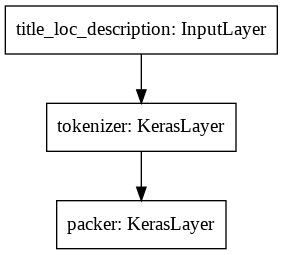

In [ ]:
tf.keras.utils.plot_model(preproc_model1)

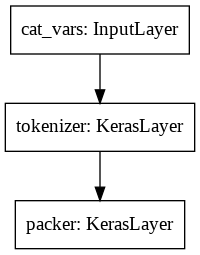

In [ ]:
tf.keras.utils.plot_model(preproc_model2)

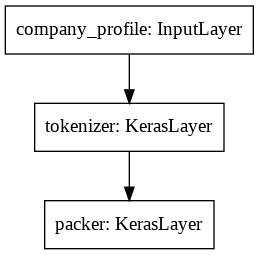

In [ ]:
tf.keras.utils.plot_model(preproc_model3)

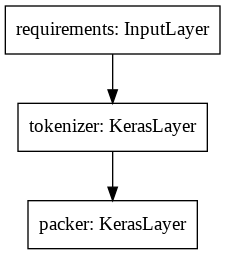

In [ ]:
tf.keras.utils.plot_model(preproc_model4)

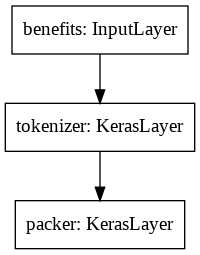

In [ ]:
tf.keras.utils.plot_model(preproc_model5)

In [ ]:
#PREPROCESSING FOR BERT - VAL DATA
val_texts=[val_text1, val_text2, val_text3, val_text4, val_text5]
val_preproc1 = preproc_model1([val_texts[0]]) #title_loc_description
val_preproc2 = preproc_model2([val_texts[1]]) #cat_vars
val_preproc3 = preproc_model3([val_texts[2]]) #company_profile
val_preproc4 = preproc_model4([val_texts[3]]) #requirements
val_preproc5 = preproc_model5([val_texts[4]]) #benefits

#PREPROCESSING FOR BERT - TEST DATA
test_texts=[test_text1, test_text2, test_text3, test_text4, test_text5]
test_preproc1 = preproc_model1([test_texts[0]]) #title_loc_description
test_preproc2 = preproc_model2([test_texts[1]]) #cat_vars
test_preproc3 = preproc_model3([test_texts[2]]) #company_profile
test_preproc4 = preproc_model4([test_texts[3]]) #requirements
test_preproc5 = preproc_model5([test_texts[4]]) #benefits

In [ ]:
def build_bert_model(encoder):
  inputs1 = dict(
        input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_word_ids1'),
        input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_mask1'),
        input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_type_ids1')
    )
  encoder1 = hub.KerasLayer(encoder, trainable=True, name='BERT_encoder1')
  net1=encoder1(inputs1)['pooled_output']

  inputs2 = dict(
        input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_word_ids2'),
        input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_mask2'),
        input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_type_ids2')
    )
  encoder2 = hub.KerasLayer(encoder, trainable=True, name='BERT_encoder2')
  net2=encoder2(inputs2)['pooled_output']

  inputs3 = dict(
        input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_word_ids3'),
        input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_mask3'),
        input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_type_ids3')
    )
  encoder3 = hub.KerasLayer(encoder, trainable=True, name='BERT_encoder3')
  net3=encoder3(inputs3)['pooled_output']

  inputs4 = dict(
        input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_word_ids4'),
        input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_mask4'),
        input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_type_ids4')
    )
  encoder4 = hub.KerasLayer(encoder, trainable=True, name='BERT_encoder4')
  net4=encoder4(inputs4)['pooled_output']
  
  inputs5 = dict(
        input_word_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_word_ids5'),
        input_mask=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_mask5'),
        input_type_ids=tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_type_ids5')
    )
  encoder5 = hub.KerasLayer(encoder, trainable=True, name='BERT_encoder5')
  net5=encoder5(inputs5)['pooled_output']
  
  inputs = tf.keras.layers.concatenate([net1, net2, net3, net4, net5])
  x = tf.keras.layers.Dropout(0.1)(inputs)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(x)
  return tf.keras.Model(inputs=[inputs1, inputs2, inputs3, inputs4, inputs5], outputs=[output])

In [ ]:
small_bert_model = build_bert_model(small_bert_encoder) 
print(small_bert_model.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask1 (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
input_type_ids1 (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
input_word_ids1 (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
input_mask2 (InputLayer)        [(None, None)]       0                                            
____________________________________________________________________________________________

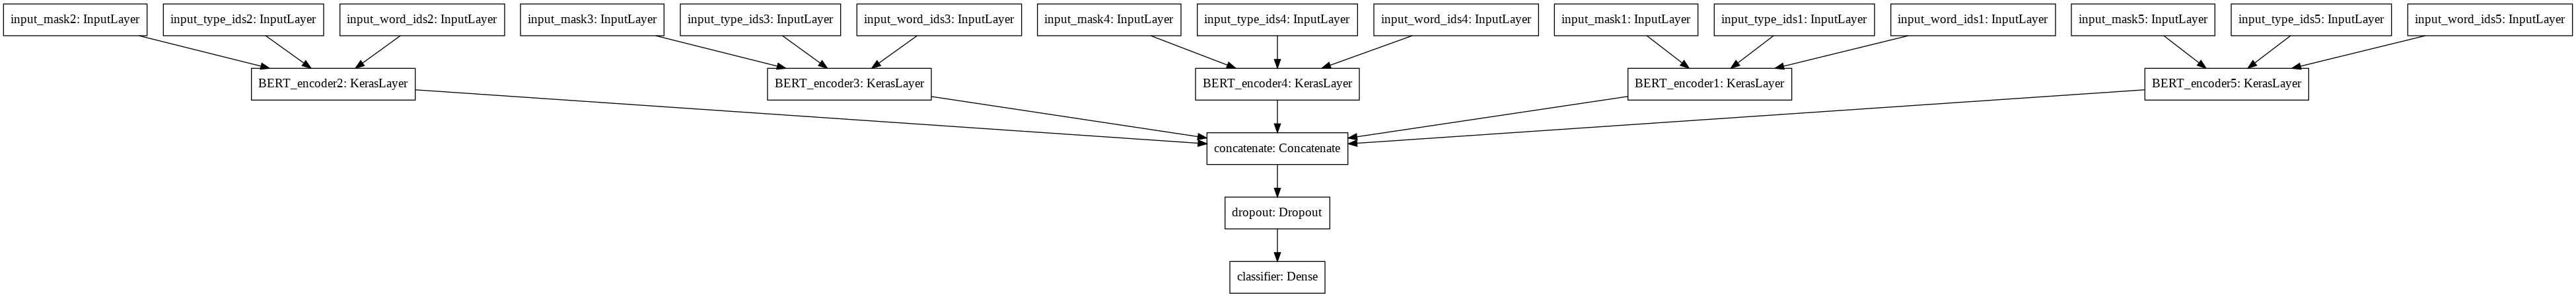

In [ ]:
tf.keras.utils.plot_model(small_bert_model)

### Fine-Tuning BERT Model \-- 

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

metrics_list = [
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.AUC(name='auc')
  ]

metrics = metrics_list

In [ ]:
epochs = 1
steps_per_epoch = len(train_t)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
print(steps_per_epoch)
print(num_train_steps)
print(num_warmup_steps)

11443
11443
1144


### Small BERT model (small_bert/bert_en_uncased_L-4_H-512_A-4)

In [ ]:
small_bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
#training model with small bert
history = small_bert_model.fit([preproc1, preproc2, preproc3, preproc4, preproc5], train_labels, epochs=1, validation_data=([val_preproc1, val_preproc2, val_preproc3, val_preproc4, val_preproc5], val_labels))

358/358 [==============================] - 14265s 40s/step - loss: 0.1671 - fp: 27.0000 - fn: 520.0000 - accuracy: 0.9522 - auc: 0.8055 - val_loss: 0.0990 - val_fp: 1.0000 - val_fn: 109.0000 - val_accuracy: 0.9616 - val_auc: 0.9625


In [ ]:
history.history

{'accuracy': [0.9521978497505188],
 'auc': [0.805534303188324],
 'fn': [520.0],
 'fp': [27.0],
 'loss': [0.16709047555923462],
 'val_accuracy': [0.9615519046783447],
 'val_auc': [0.9624773263931274],
 'val_fn': [109.0],
 'val_fp': [1.0],
 'val_loss': [0.09895870089530945]}

### Classic BERT model (bert_en_uncased_L-12_H-768_A-12) --> CANNOT RUN ON COLAB CPU

In [ ]:
# bert_model = build_bert_model(classic_bert_encoder)
# print(bert_model.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mask1 (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
input_type_ids1 (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
input_word_ids1 (InputLayer)    [(None, None)]       0                                            
__________________________________________________________________________________________________
input_mask2 (InputLayer)        [(None, None)]       0                                            
____________________________________________________________________________________________

In [ ]:
# bert_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
# CANNOT RUN -- BERT MODEL IS TOO LARGE FOR COLAB
# history = bert_model.fit([preproc1, preproc2, preproc3, preproc4, preproc5], train_labels, epochs=1, validation_data=([val_preproc1, val_preproc2, val_preproc3, val_preproc4, val_preproc5], val_labels))

In [ ]:
# history.history

### Applying the Small-BERT model to the testing set

In [ ]:
small_bert_model.evaluate([test_preproc1, test_preproc2, test_preproc3, test_preproc4, test_preproc5], test_labels)

112/112 [==============================] - 1219s 11s/step - loss: 0.0926 - fp: 4.0000 - fn: 119.0000 - accuracy: 0.9656 - auc: 0.9637
